<center><h1> Adversarial Finetuning using PatchGAN Discriminator </h1></center>

In [ ]:
import numpy as np
import torch
from torch.amp import autocast, GradScaler
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import spectral_norm
from torch.utils.data import DataLoader, Dataset, random_split
from moco_v2 import HRNetEncoderWrapper, MoCoV2
from torchinfo import summary
import cv2
import pandas as pd
import os
import ast

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/kaggle/usr/lib/moco_v2/moco_v2.py:192: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=20, border_mode=0)


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Pretrained Model Loading

In [3]:
encoder_q = HRNetEncoderWrapper(pretrained=False)
encoder_k = HRNetEncoderWrapper(pretrained=False)

moco_model = MoCoV2(encoder_q, encoder_k, K=8192)

moco_model.load_state_dict(torch.load('/kaggle/input/mocov2-hrnet/pytorch/reduced_queue_extended/1/moco_v2_new.pt', map_location=device), strict=False)

<All keys matched successfully>

In [4]:
encoder_q = moco_model.encoder_q
summary(encoder_q, input_size=(1, 1, 512, 512))

Layer (type:depth-idx)                                       Output Shape              Param #
HRNetEncoderWrapper                                          [1, 1024, 16, 16]         --
├─HighResolutionNetFeatures: 1-1                             [1, 64, 256, 256]         --
│    └─Conv2d: 2-1                                           [1, 64, 256, 256]         576
│    └─BatchNorm2d: 2-2                                      [1, 64, 256, 256]         128
│    └─ReLU: 2-3                                             [1, 64, 256, 256]         --
│    └─Conv2d: 2-4                                           [1, 64, 128, 128]         36,864
│    └─BatchNorm2d: 2-5                                      [1, 64, 128, 128]         128
│    └─ReLU: 2-6                                             [1, 64, 128, 128]         --
│    └─Sequential: 2-7                                       [1, 256, 128, 128]        --
│    │    └─Bottleneck: 3-1                                  [1, 256, 128, 128]        7

## Regression Head Addition

In [ ]:
# --- CBAM Module ---
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, reduction_ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc = nn.Sequential(
            nn.Conv2d(in_planes, in_planes // reduction_ratio, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_planes // reduction_ratio, in_planes, 1, bias=False)
        )

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        return self.sigmoid(avg_out + max_out)


class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        padding = kernel_size // 2
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_out, max_out], dim=1)
        return self.sigmoid(self.conv(x_cat))


class CBAM(nn.Module):
    def __init__(self, in_planes, reduction_ratio=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.ca = ChannelAttention(in_planes, reduction_ratio)
        self.sa = SpatialAttention(kernel_size)

    def forward(self, x):
        x = x * self.ca(x)
        x = x * self.sa(x)
        return x

def soft_argmax(heatmaps, temperature=10.0):
    B, C, H, W = heatmaps.shape
    heatmaps = F.softmax(heatmaps.view(B, C, -1)*temperature, dim=-1).view(B, C, H, W)

    # Create coordinate grid
    xs = torch.linspace(0, W - 1, W, device=heatmaps.device)
    ys = torch.linspace(0, H - 1, H, device=heatmaps.device)
    grid_y, grid_x = torch.meshgrid(ys, xs, indexing="ij")  # [H, W]

    exp_x = torch.sum(heatmaps * grid_x[None, None, :, :], dim=(2, 3))
    exp_y = torch.sum(heatmaps * grid_y[None, None, :, :], dim=(2, 3))
    coords = torch.stack([exp_x, exp_y], dim=-1)  # [B, C, 2]

    # Normalize
    coords[..., 0] /= (W - 1)
    coords[..., 1] /= (H - 1)
    
    return coords

In [6]:
class HRNetWithHeatmapDecoder(nn.Module):
    def __init__(self, hrnet_encoder, num_landmarks=3):
        super(HRNetWithHeatmapDecoder, self).__init__()
        # Expected output shape: [B, 1024, 16, 16]
        self.encoder = hrnet_encoder

        self.decoder = nn.Sequential(
            nn.Conv2d(1024, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            CBAM(512),

            nn.Upsample(scale_factor=2, mode='bilinear',
                        align_corners=False),  # 32x32
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            CBAM(256),

            nn.Upsample(scale_factor=2, mode='bilinear',
                        align_corners=False),  # 64x64
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            CBAM(128),

            nn.Upsample(scale_factor=2, mode='bilinear',
                        align_corners=False),  # 128x128
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Upsample(scale_factor=2, mode='bilinear',
                        align_corners=False),  # 256x256
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.Upsample(scale_factor=2, mode='bilinear',
                        align_corners=False),  # 512x512
            # Final output: [B, num_landmarks, 512, 512]
            nn.Conv2d(32, num_landmarks, kernel_size=1)
        )

    def forward(self, x):
        features = self.encoder(x)
        heatmaps = self.decoder(features)
        coords = soft_argmax(heatmaps)
        return heatmaps, coords

In [7]:
r_model = HRNetWithHeatmapDecoder(encoder_q)  # Adjust input_channels based on the backbone output
r_model.to(device)
summary(r_model, input_size=(1, 1, 512, 512))  

Layer (type:depth-idx)                                            Output Shape              Param #
HRNetWithHeatmapDecoder                                           [1, 3, 512, 512]          --
├─HRNetEncoderWrapper: 1-1                                        [1, 1024, 16, 16]         --
│    └─HighResolutionNetFeatures: 2-1                             [1, 64, 256, 256]         --
│    │    └─Conv2d: 3-1                                           [1, 64, 256, 256]         576
│    │    └─BatchNorm2d: 3-2                                      [1, 64, 256, 256]         128
│    │    └─ReLU: 3-3                                             [1, 64, 256, 256]         --
│    │    └─Conv2d: 3-4                                           [1, 64, 128, 128]         36,864
│    │    └─BatchNorm2d: 3-5                                      [1, 64, 128, 128]         128
│    │    └─ReLU: 3-6                                             [1, 64, 128, 128]         --
│    │    └─Sequential: 3-7           

## PatchGAN Discriminator

In [8]:
class SpectralPatchGANDiscriminator(nn.Module):
    def __init__(self, in_channels=3, base_channels=64):
        super().__init__()
        self.net = nn.Sequential(
            # Input: [B, 3, H, W]
            spectral_norm(nn.Conv2d(in_channels, base_channels,
                          kernel_size=4, stride=2, padding=1)),
            nn.LeakyReLU(0.2, inplace=True),

            spectral_norm(nn.Conv2d(base_channels, base_channels *
                          2, kernel_size=4, stride=2, padding=1)),
            nn.LeakyReLU(0.2, inplace=True),

            spectral_norm(nn.Conv2d(
                base_channels * 2, base_channels * 4, kernel_size=4, stride=2, padding=1)),
            nn.LeakyReLU(0.2, inplace=True),

            spectral_norm(nn.Conv2d(
                base_channels * 4, base_channels * 8, kernel_size=4, stride=1, padding=1)),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(base_channels * 8, 1, kernel_size=4,
                      stride=1, padding=1)  # No SN here
        )

    def forward(self, x):
        return self.net(x)  # Output: [B, 1, H', W']

In [9]:
summary(SpectralPatchGANDiscriminator(), input_size=(1, 3, 512, 512))

Layer (type:depth-idx)                   Output Shape              Param #
SpectralPatchGANDiscriminator            [1, 1, 62, 62]            --
├─Sequential: 1-1                        [1, 1, 62, 62]            --
│    └─Conv2d: 2-1                       [1, 64, 256, 256]         3,136
│    └─LeakyReLU: 2-2                    [1, 64, 256, 256]         --
│    └─Conv2d: 2-3                       [1, 128, 128, 128]        131,200
│    └─LeakyReLU: 2-4                    [1, 128, 128, 128]        --
│    └─Conv2d: 2-5                       [1, 256, 64, 64]          524,544
│    └─LeakyReLU: 2-6                    [1, 256, 64, 64]          --
│    └─Conv2d: 2-7                       [1, 512, 63, 63]          2,097,664
│    └─LeakyReLU: 2-8                    [1, 512, 63, 63]          --
│    └─Conv2d: 2-9                       [1, 1, 62, 62]            8,193
Total params: 2,764,737
Trainable params: 2,764,737
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 1.27
Input size (MB):

## Dataset Preparation

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

class AddSpeckleNoise(A.ImageOnlyTransform):
    
    """
    Add speckle noise to the image.
    Speckle noise is multiplicative noise that can be added to images.
    It is often used in ultrasound imaging to simulate realistic noise conditions.
    """
    def __init__(self, mean=0.0, std=0.01, always_apply=False, p=0.5):
        super(AddSpeckleNoise, self).__init__(always_apply, p)
        self.mean = mean
        self.std = std

    def apply(self, image, **params):
        noise = np.random.normal(
            self.mean, self.std, image.shape).astype(np.float32)
        noisy_image = image + image * noise
        return np.clip(noisy_image, 0, 255).astype(np.uint8)
    

LABELLED_AUGMENTATIONS = A.Compose([
    A.OneOf([
        A.ElasticTransform(alpha=5, sigma=10, alpha_affine=10, border_mode=0)
    ], p=0.8),

    A.OneOf([
        A.RandomBrightnessContrast(),
        A.GaussianBlur(blur_limit=(3, 5)),
        AddSpeckleNoise(mean=0.0, std=0.01)
    ], p=0.5),

    A.Normalize(mean=[0.0], std=[255.0]),
    ToTensorV2()
], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))

/tmp/ipykernel_19/2771167181.py:25: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=20, border_mode=0)


In [11]:
class HeatmapLandmarkDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None, train=True, num_views=None, heatmap_size=512, sigma=2.0):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.train = train
        self.heatmap_size = heatmap_size
        self.sigma = sigma
        self.transform = transform
        self.num_views = num_views if hasattr(self, 'num_views') else 1

    def __len__(self):
        return len(self.data)

    def generate_heatmap(self, center_x, center_y, height, width):
        x = np.arange(0, width, 1, np.float32)
        y = np.arange(0, height, 1, np.float32)
        y = y[:, np.newaxis]
        heatmap = np.exp(-((x - center_x) ** 2 + (y - center_y)
                         ** 2) / (2 * self.sigma ** 2))
        return heatmap

    def __getitem__(self, index):
        row = self.data.iloc[index]
        filename = row['Filename']
        img_path = os.path.join(self.img_dir, filename)

        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        # Try parsing landmarks
        try:
            ps1 = ast.literal_eval(row["PS1"])
            ps2 = ast.literal_eval(row["PS2"])
            fh = ast.literal_eval(row["FH1"])
            keypoints = [list(ps1), list(ps2), list(fh)]
            if len(keypoints) != 3 or any(len(kp) != 2 for kp in keypoints):
                raise ValueError(
                    f"Invalid keypoints at index {index}: {keypoints}")

        except Exception as e:
            raise ValueError(
                f"Error parsing keypoints at index {index}: {e}, row: {row}")

        # Ensure exactly 3 keypoints
        if not (isinstance(keypoints, list) and len(keypoints) == 3 and all(len(kp) == 2 for kp in keypoints)):
            raise ValueError(
                f"Invalid or incomplete keypoints at index {index}: {keypoints}")

        if self.transform:
            image, keypoints = self.apply_transform_with_keypoints(
                image=image, keypoints=keypoints, num_views=self.num_views)

            if not (isinstance(keypoints, list) and len(keypoints) == 3 and all(len(kp) == 2 for kp in keypoints)):
                raise ValueError(
                    f"Invalid or incomplete keypoints at index {index}: {keypoints}")

        # Generate heatmaps
        heatmaps = np.zeros(
            (3, self.heatmap_size, self.heatmap_size), dtype=np.float32)
        img_height, img_width = image.shape[1], image.shape[2]
        scale_x = self.heatmap_size / img_width
        scale_y = self.heatmap_size / img_height

        for i, kp in enumerate(keypoints):
            if i >= len(keypoints) or len(keypoints[i]) != 2:
                raise IndexError(
                    f"Missing or invalid keypoint {i} at index {index}: {keypoints}")
            x = int(kp[0] * scale_x)
            y = int(kp[1] * scale_y)
            x = max(0, min(x, self.heatmap_size - 1))
            y = max(0, min(y, self.heatmap_size - 1))
            heatmaps[i] = self.generate_heatmap(
                x, y, self.heatmap_size, self.heatmap_size)

        heatmaps = torch.from_numpy(heatmaps)

        # Normalized landmark coordinates
        landmarks = [
            keypoints[0][0] / img_width, keypoints[0][1] / img_height,
            keypoints[1][0] / img_width, keypoints[1][1] / img_height,
            keypoints[2][0] / img_width, keypoints[2][1] / img_height
        ]

        landmarks = torch.tensor(landmarks, dtype=torch.float32)

        return image, heatmaps, landmarks

    def apply_transform_with_keypoints(self, image, keypoints, num_views=1):
        """
        Apply albumentations transform to image and keypoints, generating multiple views.
        
        Args:
            image (PIL.Image): Input image (grayscale)
            keypoints (list): List of (x, y) tuples
            num_views (int): Number of augmented views to generate

        Returns:
            If num_views == 1:
                image_tensor (torch.Tensor): Transformed image
                transformed_keypoints (list): Transformed (x, y) keypoints
            If num_views > 1:
                list of tuples [(image_tensor, transformed_keypoints), ...] for each view
        """
        # Convert PIL to numpy
        image_np = np.array(image)

        # Convert grayscale to 3D for albumentations if needed
        if image_np.ndim == 2:
            image_np = image_np[:, :, None]

        if num_views == 1:
            # Apply the transform
            transformed = self.transform(image=image_np, keypoints=keypoints)
            image_tensor = transformed["image"]
            transformed_keypoints = transformed["keypoints"]
            return image_tensor, transformed_keypoints
        else:
            # Generate multiple views
            views = []
            for _ in range(num_views):
                transformed = self.transform(
                    image=image_np, keypoints=keypoints)
                views.append((transformed["image"], transformed["keypoints"]))
            return views

In [ ]:
labelled_dataset = HeatmapLandmarkDataset(
    csv_file='Training/Labeled cases/label.csv',
    img_dir='Training/Labeled cases',
    transform=LABELLED_AUGMENTATIONS,
    num_views=3  
)

torch.manual_seed(42)
train_size = int(0.8 * len(labelled_dataset))
val_size = len(labelled_dataset) - train_size
train_dataset, val_dataset = random_split(labelled_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4, pin_memory=True)

## Training Loop

In [13]:
def freeze_encoder(model):
    for param in model.encoder.parameters():
        param.requires_grad = False

def unfreeze_encoder(model):
    for name, param in model.encoder.backbone.named_parameters():
        if "stage3" in name:
            param.requires_grad = True

def unfreeze_encoder_stage2(model):
    for name, param in model.encoder.backbone.named_parameters():
        if "stage2" in name:
            param.requires_grad = True

In [ ]:
def entropy_loss(heatmaps):
    B, C, H, W = heatmaps.shape
    prob = F.softmax(heatmaps.view(B, C, -1), dim=-1)
    entropy = -torch.sum(prob * torch.log(prob + 1e-8), dim=-1)
    return entropy.mean()

In [15]:
N_EPOCHS = 400
G_LEARNING_RATE = 3e-4
D_LEARNING_RATE = 5e-5
UNFREEZE_EPOCHS = 150
UNFREEZE_EPOCHS2 = 250

In [16]:
# Loss functions
mse_loss = nn.MSELoss()
bce_loss = nn.BCEWithLogitsLoss()

# Mixed precision
scaler_G = GradScaler()
scaler_D = GradScaler()

# Models
encoder = encoder_q
generator = HRNetWithHeatmapDecoder(encoder).to(device)
discriminator = SpectralPatchGANDiscriminator(in_channels=3, base_channels=64).to(device)

# Optimizers
optimizer_G = torch.optim.AdamW(generator.parameters(), lr=G_LEARNING_RATE, weight_decay=1e-4)
optimizer_D = torch.optim.AdamW(discriminator.parameters(), lr=D_LEARNING_RATE, weight_decay=1e-4)

# scheduler
scheduler_G = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_G, T_max=N_EPOCHS, eta_min=5e-6)
scheduler_D = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_D, T_max=N_EPOCHS, eta_min=1e-7)

In [ ]:
# === Training Epoch ===
def train_epoch(generator, discriminator,
                dataloader, optimizer_G, optimizer_D,
                scaler_G, scaler_D,
                device, lambda_adv=0.01):

    generator.train()
    discriminator.train()

    total = {'heatmap': 0, 'coord': 0, 'adv_G': 0, 'adv_D': 0}
    num_batches = len(dataloader)

    for images, gt_heatmaps, gt_coords in tqdm(dataloader, desc="Training"):
        images = images.to(device)
        gt_heatmaps = gt_heatmaps.to(device)
        gt_coords = gt_coords.to(device)

        # === Generator forward ===
        with autocast(device_type=device.type):
            pred_heatmaps, pred_coords = generator(images)
            pred_coords = pred_coords.reshape(-1, 6)
            
            # Losses
            loss_heatmap = mse_loss(pred_heatmaps, gt_heatmaps)
            loss_coords = mse_loss(pred_coords, gt_coords)

            # Adversarial loss (G tries to fool D)
            pred_D_fake = discriminator(pred_heatmaps)
            adv_loss_G = bce_loss(pred_D_fake, torch.ones_like(pred_D_fake))

            entropy_penalty = entropy_loss(pred_heatmaps)
            loss_G = loss_heatmap + 10 * loss_coords + lambda_adv * adv_loss_G + 0.001 * entropy_penalty

        # === Generator Backward ===
        optimizer_G.zero_grad()
        scaler_G.scale(loss_G).backward()
        scaler_G.step(optimizer_G)
        scaler_G.update()

        # === Discriminator forward ===
        with autocast(device_type=device.type):
            pred_D_fake = discriminator(pred_heatmaps.detach())
            pred_D_real = discriminator(gt_heatmaps)

            adv_loss_D_real = bce_loss(
                pred_D_real, torch.ones_like(pred_D_real))
            adv_loss_D_fake = bce_loss(
                pred_D_fake, torch.zeros_like(pred_D_fake))
            adv_loss_D = (adv_loss_D_real + adv_loss_D_fake) / 2

        # === Discriminator Backward ===
        optimizer_D.zero_grad()
        scaler_D.scale(adv_loss_D).backward()
        scaler_D.step(optimizer_D)
        scaler_D.update()

        # === Logging ===
        total['heatmap'] += loss_heatmap.item()
        total['coord'] += loss_coords.item()
        total['adv_G'] += adv_loss_G.item()
        total['adv_D'] += adv_loss_D.item()

        # === Clean up memory ===
        del images, gt_heatmaps, gt_coords
        del pred_heatmaps, pred_coords
        del pred_D_fake, pred_D_real
        del loss_heatmap, loss_coords, adv_loss_G, adv_loss_D, adv_loss_D_real, adv_loss_D_fake, loss_G
        del entropy_penalty
        torch.cuda.empty_cache()

    return {k: v / num_batches for k, v in total.items()}


# === Validation Epoch ===
@torch.no_grad()
def validate_epoch(generator, discriminator, dataloader, device, lambda_adv=0.01):
    generator.eval()
    discriminator.eval()

    total = {'heatmap': 0, 'coord': 0, 'adv_G': 0, 'adv_D': 0}
    num_batches = len(dataloader)

    for images, gt_heatmaps, gt_coords in tqdm(dataloader, desc="Validation"):
        images = images.to(device)
        gt_heatmaps = gt_heatmaps.to(device)
        gt_coords = gt_coords.to(device)

        with autocast(device_type=device.type):
            pred_heatmaps, pred_coords = generator(images)
            pred_coords = pred_coords.reshape(-1, 6)
            
            loss_heatmap = mse_loss(pred_heatmaps, gt_heatmaps)
            loss_coords = mse_loss(pred_coords, gt_coords)

            # Adversarial losses
            pred_D_fake = discriminator(pred_heatmaps)
            pred_D_real = discriminator(gt_heatmaps)

            adv_loss_G = bce_loss(pred_D_fake, torch.ones_like(pred_D_fake))
            adv_loss_D_real = bce_loss(
                pred_D_real, torch.ones_like(pred_D_real))
            adv_loss_D_fake = bce_loss(
                pred_D_fake, torch.zeros_like(pred_D_fake))
            adv_loss_D = (adv_loss_D_real + adv_loss_D_fake) / 2

        # Logging
        total['heatmap'] += loss_heatmap.item()
        total['coord'] += loss_coords.item()
        total['adv_G'] += adv_loss_G.item()
        total['adv_D'] += adv_loss_D.item()

         # === Clean up memory ===
        del images, gt_heatmaps, gt_coords
        del pred_heatmaps, pred_coords
        del pred_D_fake, pred_D_real
        del loss_heatmap, loss_coords, adv_loss_G, adv_loss_D, adv_loss_D_real, adv_loss_D_fake
        torch.cuda.empty_cache()

    return {k: v / num_batches for k, v in total.items()}

In [18]:
image, _, coords = next(iter(train_loader))
_, pred_coords = generator(image.to(device))
print(coords[0])
print(pred_coords.reshape(-1, 6)[0])

tensor([0.5684, 0.1562, 0.3379, 0.1758, 0.6895, 0.4160])
tensor([0.3890, 0.2843, 0.3263, 0.6256, 0.6184, 0.6284], device='cuda:0',
       grad_fn=<SelectBackward0>)


In [19]:
train_losses = []
val_losses = []

best_val_coord_loss = float('inf')
save_path_G = "best_generator.pt"
save_path_D = "best_discriminator.pt" 

freeze_encoder(generator)

for epoch in range(N_EPOCHS):

    if epoch == UNFREEZE_EPOCHS:
        unfreeze_encoder(generator)
        print(f"Unfreezing Encoder stage-3")

    if epoch == UNFREEZE_EPOCHS2:
        unfreeze_encoder_stage2(generator)
        print(f"Unfreezing Encoder stage-2")
    
    print(f"\n======= Epoch {epoch+1}/{N_EPOCHS} =======\n")

    train_logs = train_epoch(generator, discriminator, train_loader,
                             optimizer_G, optimizer_D,
                             scaler_G, scaler_D,
                             device)

    val_logs = validate_epoch(generator, discriminator, val_loader, device)

    scheduler_G.step()
    scheduler_D.step()

    train_losses.append(train_logs)
    val_losses.append(val_logs)

    print(f"[Train] Heatmap: {train_logs['heatmap']:.6f} | Coord: {train_logs['coord']:.6f} | Adv_G: {train_logs['adv_G']:.6f} | Adv_D: {train_logs['adv_D']:.6f}")
    print(
        f"[ Val ] Heatmap: {val_logs['heatmap']:.6f} | Coord: {val_logs['coord']:.6f} | Adv_G: {val_logs['adv_G']:.6f} | Adv_D: {val_logs['adv_D']:.6f}")
    
    # Save best model
    if val_logs['coord'] < best_val_coord_loss:
        best_val_coord_loss = val_logs['coord']
        torch.save(generator.state_dict(), save_path_G)
        torch.save(discriminator.state_dict(), save_path_D)
        print(
            f"🔽 Best model saved (val coord loss = {best_val_coord_loss:.6f})")


======= Epoch 1/400 =======



Validation: 100%|██████████| 15/15 [00:06<00:00,  2.45it/s]


[Train] Heatmap: 0.083439 | Coord: 0.008979 | Adv_G: 2.818326 | Adv_D: 0.356972
[ Val ] Heatmap: 0.013079 | Coord: 0.002785 | Adv_G: 2.256083 | Adv_D: 0.473600
🔽 Best model saved (val coord loss = 0.002785)

======= Epoch 2/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.55it/s]


[Train] Heatmap: 0.014482 | Coord: 0.002968 | Adv_G: 2.400220 | Adv_D: 0.330240
[ Val ] Heatmap: 0.008548 | Coord: 0.003019 | Adv_G: 3.052910 | Adv_D: 0.263160

======= Epoch 3/400 =======



Validation: 100%|██████████| 15/15 [00:06<00:00,  2.50it/s]


[Train] Heatmap: 0.006065 | Coord: 0.002081 | Adv_G: 2.897859 | Adv_D: 0.306428
[ Val ] Heatmap: 0.005521 | Coord: 0.001576 | Adv_G: 3.052528 | Adv_D: 0.331625
🔽 Best model saved (val coord loss = 0.001576)

======= Epoch 4/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.56it/s]


[Train] Heatmap: 0.004001 | Coord: 0.001929 | Adv_G: 2.843507 | Adv_D: 0.341838
[ Val ] Heatmap: 0.003884 | Coord: 0.001193 | Adv_G: 3.101217 | Adv_D: 0.325068
🔽 Best model saved (val coord loss = 0.001193)

======= Epoch 5/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.60it/s]


[Train] Heatmap: 0.002787 | Coord: 0.001415 | Adv_G: 2.665087 | Adv_D: 0.378614
[ Val ] Heatmap: 0.002400 | Coord: 0.001324 | Adv_G: 2.460238 | Adv_D: 0.399384

======= Epoch 6/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.51it/s]


[Train] Heatmap: 0.002370 | Coord: 0.001570 | Adv_G: 2.914215 | Adv_D: 0.346188
[ Val ] Heatmap: 0.002242 | Coord: 0.001537 | Adv_G: 2.693297 | Adv_D: 0.391955

======= Epoch 7/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.55it/s]


[Train] Heatmap: 0.002331 | Coord: 0.001651 | Adv_G: 2.868027 | Adv_D: 0.354627
[ Val ] Heatmap: 0.001941 | Coord: 0.001708 | Adv_G: 2.393681 | Adv_D: 0.441104

======= Epoch 8/400 =======



Validation: 100%|██████████| 15/15 [00:06<00:00,  2.47it/s]


[Train] Heatmap: 0.001925 | Coord: 0.001453 | Adv_G: 2.802890 | Adv_D: 0.366906
[ Val ] Heatmap: 0.001687 | Coord: 0.002479 | Adv_G: 2.921715 | Adv_D: 0.389056

======= Epoch 9/400 =======



Validation: 100%|██████████| 15/15 [00:06<00:00,  2.43it/s]


[Train] Heatmap: 0.001780 | Coord: 0.001229 | Adv_G: 2.724101 | Adv_D: 0.361443
[ Val ] Heatmap: 0.001649 | Coord: 0.001365 | Adv_G: 2.828743 | Adv_D: 0.404400

======= Epoch 10/400 =======



Validation: 100%|██████████| 15/15 [00:06<00:00,  2.43it/s]


[Train] Heatmap: 0.001556 | Coord: 0.001286 | Adv_G: 2.615503 | Adv_D: 0.367880
[ Val ] Heatmap: 0.001624 | Coord: 0.001131 | Adv_G: 2.275129 | Adv_D: 0.472198
🔽 Best model saved (val coord loss = 0.001131)

======= Epoch 11/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.52it/s]


[Train] Heatmap: 0.001861 | Coord: 0.001406 | Adv_G: 2.941035 | Adv_D: 0.333971
[ Val ] Heatmap: 0.001793 | Coord: 0.001367 | Adv_G: 1.949271 | Adv_D: 0.500803

======= Epoch 12/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.51it/s]


[Train] Heatmap: 0.001503 | Coord: 0.001224 | Adv_G: 2.713489 | Adv_D: 0.354504
[ Val ] Heatmap: 0.001464 | Coord: 0.000909 | Adv_G: 2.681085 | Adv_D: 0.427040
🔽 Best model saved (val coord loss = 0.000909)

======= Epoch 13/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.52it/s]


[Train] Heatmap: 0.001381 | Coord: 0.001080 | Adv_G: 2.515527 | Adv_D: 0.374264
[ Val ] Heatmap: 0.001523 | Coord: 0.001286 | Adv_G: 2.172025 | Adv_D: 0.451716

======= Epoch 14/400 =======



Validation: 100%|██████████| 15/15 [00:06<00:00,  2.47it/s]


[Train] Heatmap: 0.001430 | Coord: 0.001177 | Adv_G: 2.656887 | Adv_D: 0.332232
[ Val ] Heatmap: 0.001455 | Coord: 0.001155 | Adv_G: 1.900490 | Adv_D: 0.412746

======= Epoch 15/400 =======



Validation: 100%|██████████| 15/15 [00:06<00:00,  2.48it/s]


[Train] Heatmap: 0.001443 | Coord: 0.001136 | Adv_G: 2.818205 | Adv_D: 0.290907
[ Val ] Heatmap: 0.001630 | Coord: 0.001011 | Adv_G: 2.409077 | Adv_D: 0.393236

======= Epoch 16/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.51it/s]


[Train] Heatmap: 0.001660 | Coord: 0.001177 | Adv_G: 2.516587 | Adv_D: 0.289520
[ Val ] Heatmap: 0.001934 | Coord: 0.001036 | Adv_G: 1.682363 | Adv_D: 0.435229

======= Epoch 17/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.57it/s]


[Train] Heatmap: 0.001744 | Coord: 0.001108 | Adv_G: 2.436610 | Adv_D: 0.320524
[ Val ] Heatmap: 0.001687 | Coord: 0.001308 | Adv_G: 2.061958 | Adv_D: 0.431857

======= Epoch 18/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.60it/s]


[Train] Heatmap: 0.001708 | Coord: 0.001122 | Adv_G: 2.335223 | Adv_D: 0.321259
[ Val ] Heatmap: 0.001714 | Coord: 0.000988 | Adv_G: 1.819124 | Adv_D: 0.445131

======= Epoch 19/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.61it/s]


[Train] Heatmap: 0.001834 | Coord: 0.001005 | Adv_G: 2.483148 | Adv_D: 0.288639
[ Val ] Heatmap: 0.001746 | Coord: 0.000988 | Adv_G: 1.913066 | Adv_D: 0.405781

======= Epoch 20/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.56it/s]


[Train] Heatmap: 0.001653 | Coord: 0.000885 | Adv_G: 2.429507 | Adv_D: 0.325317
[ Val ] Heatmap: 0.001798 | Coord: 0.001014 | Adv_G: 1.417969 | Adv_D: 0.388799

======= Epoch 21/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.58it/s]


[Train] Heatmap: 0.001600 | Coord: 0.000865 | Adv_G: 2.547608 | Adv_D: 0.338683
[ Val ] Heatmap: 0.001519 | Coord: 0.000737 | Adv_G: 2.053829 | Adv_D: 0.437676
🔽 Best model saved (val coord loss = 0.000737)

======= Epoch 22/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.55it/s]


[Train] Heatmap: 0.001556 | Coord: 0.000809 | Adv_G: 2.257582 | Adv_D: 0.367063
[ Val ] Heatmap: 0.001462 | Coord: 0.000884 | Adv_G: 2.198234 | Adv_D: 0.490621

======= Epoch 23/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.55it/s]


[Train] Heatmap: 0.001604 | Coord: 0.000932 | Adv_G: 2.260562 | Adv_D: 0.322806
[ Val ] Heatmap: 0.001633 | Coord: 0.000798 | Adv_G: 2.437977 | Adv_D: 0.402389

======= Epoch 24/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.64it/s]


[Train] Heatmap: 0.001564 | Coord: 0.000795 | Adv_G: 2.530248 | Adv_D: 0.302611
[ Val ] Heatmap: 0.001499 | Coord: 0.001552 | Adv_G: 1.588907 | Adv_D: 0.374773

======= Epoch 25/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.60it/s]


[Train] Heatmap: 0.001504 | Coord: 0.000885 | Adv_G: 2.573484 | Adv_D: 0.292926
[ Val ] Heatmap: 0.001635 | Coord: 0.000757 | Adv_G: 2.360167 | Adv_D: 0.300012

======= Epoch 26/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.51it/s]


[Train] Heatmap: 0.001572 | Coord: 0.000791 | Adv_G: 2.489733 | Adv_D: 0.333782
[ Val ] Heatmap: 0.001498 | Coord: 0.001211 | Adv_G: 2.325113 | Adv_D: 0.426934

======= Epoch 27/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.54it/s]


[Train] Heatmap: 0.001449 | Coord: 0.000808 | Adv_G: 2.770429 | Adv_D: 0.299771
[ Val ] Heatmap: 0.001500 | Coord: 0.000819 | Adv_G: 1.000960 | Adv_D: 0.670133

======= Epoch 28/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.65it/s]


[Train] Heatmap: 0.001411 | Coord: 0.000838 | Adv_G: 2.816031 | Adv_D: 0.264043
[ Val ] Heatmap: 0.001439 | Coord: 0.000811 | Adv_G: 1.907062 | Adv_D: 0.497492

======= Epoch 29/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


[Train] Heatmap: 0.001522 | Coord: 0.000880 | Adv_G: 2.454069 | Adv_D: 0.337131
[ Val ] Heatmap: 0.001438 | Coord: 0.001907 | Adv_G: 1.959695 | Adv_D: 0.597008

======= Epoch 30/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


[Train] Heatmap: 0.001430 | Coord: 0.000771 | Adv_G: 2.269670 | Adv_D: 0.343618
[ Val ] Heatmap: 0.001372 | Coord: 0.000888 | Adv_G: 1.891360 | Adv_D: 0.527380

======= Epoch 31/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.68it/s]


[Train] Heatmap: 0.001353 | Coord: 0.000777 | Adv_G: 2.530998 | Adv_D: 0.295943
[ Val ] Heatmap: 0.001316 | Coord: 0.001555 | Adv_G: 1.472658 | Adv_D: 0.407732

======= Epoch 32/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.65it/s]


[Train] Heatmap: 0.001360 | Coord: 0.000855 | Adv_G: 2.828997 | Adv_D: 0.255581
[ Val ] Heatmap: 0.001614 | Coord: 0.000969 | Adv_G: 2.312204 | Adv_D: 0.390151

======= Epoch 33/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.69it/s]


[Train] Heatmap: 0.001401 | Coord: 0.000834 | Adv_G: 2.875119 | Adv_D: 0.285739
[ Val ] Heatmap: 0.001525 | Coord: 0.000950 | Adv_G: 2.953126 | Adv_D: 0.431507

======= Epoch 34/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


[Train] Heatmap: 0.001435 | Coord: 0.000986 | Adv_G: 3.374478 | Adv_D: 0.242635
[ Val ] Heatmap: 0.001794 | Coord: 0.002217 | Adv_G: 2.245025 | Adv_D: 0.234321

======= Epoch 35/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.61it/s]


[Train] Heatmap: 0.001503 | Coord: 0.000909 | Adv_G: 2.910923 | Adv_D: 0.286546
[ Val ] Heatmap: 0.001473 | Coord: 0.001004 | Adv_G: 2.981106 | Adv_D: 0.295428

======= Epoch 36/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.64it/s]


[Train] Heatmap: 0.001426 | Coord: 0.000849 | Adv_G: 3.576708 | Adv_D: 0.239488
[ Val ] Heatmap: 0.001556 | Coord: 0.000987 | Adv_G: 2.062246 | Adv_D: 0.482740

======= Epoch 37/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.67it/s]


[Train] Heatmap: 0.001360 | Coord: 0.000787 | Adv_G: 2.272996 | Adv_D: 0.357780
[ Val ] Heatmap: 0.001244 | Coord: 0.001116 | Adv_G: 0.661712 | Adv_D: 0.797775

======= Epoch 38/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.64it/s]


[Train] Heatmap: 0.001273 | Coord: 0.000771 | Adv_G: 2.427048 | Adv_D: 0.365206
[ Val ] Heatmap: 0.001280 | Coord: 0.000945 | Adv_G: 1.520637 | Adv_D: 0.551242

======= Epoch 39/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.66it/s]


[Train] Heatmap: 0.001338 | Coord: 0.000826 | Adv_G: 2.423051 | Adv_D: 0.352024
[ Val ] Heatmap: 0.001274 | Coord: 0.000830 | Adv_G: 1.708873 | Adv_D: 0.498272

======= Epoch 40/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.65it/s]


[Train] Heatmap: 0.001257 | Coord: 0.000766 | Adv_G: 2.686982 | Adv_D: 0.297855
[ Val ] Heatmap: 0.001302 | Coord: 0.000903 | Adv_G: 2.245352 | Adv_D: 0.359892

======= Epoch 41/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.64it/s]


[Train] Heatmap: 0.001319 | Coord: 0.000816 | Adv_G: 3.272566 | Adv_D: 0.222335
[ Val ] Heatmap: 0.001493 | Coord: 0.001104 | Adv_G: 2.594227 | Adv_D: 0.292496

======= Epoch 42/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.66it/s]


[Train] Heatmap: 0.001415 | Coord: 0.001055 | Adv_G: 3.233840 | Adv_D: 0.288687
[ Val ] Heatmap: 0.001307 | Coord: 0.001020 | Adv_G: 2.546699 | Adv_D: 0.460891

======= Epoch 43/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.57it/s]


[Train] Heatmap: 0.001278 | Coord: 0.000773 | Adv_G: 2.395057 | Adv_D: 0.364120
[ Val ] Heatmap: 0.001085 | Coord: 0.000969 | Adv_G: 2.040004 | Adv_D: 0.432914

======= Epoch 44/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.67it/s]


[Train] Heatmap: 0.001104 | Coord: 0.000726 | Adv_G: 2.578266 | Adv_D: 0.315876
[ Val ] Heatmap: 0.001090 | Coord: 0.000856 | Adv_G: 2.308007 | Adv_D: 0.375355

======= Epoch 45/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.52it/s]


[Train] Heatmap: 0.001084 | Coord: 0.000827 | Adv_G: 2.731007 | Adv_D: 0.309479
[ Val ] Heatmap: 0.001088 | Coord: 0.000780 | Adv_G: 1.777523 | Adv_D: 0.546772

======= Epoch 46/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.65it/s]


[Train] Heatmap: 0.001114 | Coord: 0.000752 | Adv_G: 2.444801 | Adv_D: 0.369726
[ Val ] Heatmap: 0.000962 | Coord: 0.000778 | Adv_G: 2.154616 | Adv_D: 0.473764

======= Epoch 47/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.61it/s]


[Train] Heatmap: 0.001085 | Coord: 0.000792 | Adv_G: 2.577611 | Adv_D: 0.305826
[ Val ] Heatmap: 0.001156 | Coord: 0.000824 | Adv_G: 2.274626 | Adv_D: 0.477783

======= Epoch 48/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.60it/s]


[Train] Heatmap: 0.001188 | Coord: 0.000868 | Adv_G: 2.780238 | Adv_D: 0.301854
[ Val ] Heatmap: 0.001205 | Coord: 0.000784 | Adv_G: 2.188482 | Adv_D: 0.420038

======= Epoch 49/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.66it/s]


[Train] Heatmap: 0.001133 | Coord: 0.000752 | Adv_G: 3.095444 | Adv_D: 0.293933
[ Val ] Heatmap: 0.001130 | Coord: 0.001170 | Adv_G: 1.575005 | Adv_D: 0.481505

======= Epoch 50/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


[Train] Heatmap: 0.001096 | Coord: 0.000760 | Adv_G: 2.993652 | Adv_D: 0.294784
[ Val ] Heatmap: 0.001042 | Coord: 0.000865 | Adv_G: 2.004245 | Adv_D: 0.408762

======= Epoch 51/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.59it/s]


[Train] Heatmap: 0.001093 | Coord: 0.000788 | Adv_G: 2.815601 | Adv_D: 0.360523
[ Val ] Heatmap: 0.001019 | Coord: 0.001108 | Adv_G: 2.624809 | Adv_D: 0.428912

======= Epoch 52/400 =======



Validation: 100%|██████████| 15/15 [00:06<00:00,  2.38it/s]


[Train] Heatmap: 0.001056 | Coord: 0.000734 | Adv_G: 2.931691 | Adv_D: 0.310570
[ Val ] Heatmap: 0.001114 | Coord: 0.000787 | Adv_G: 2.393733 | Adv_D: 0.594817

======= Epoch 53/400 =======



Validation: 100%|██████████| 15/15 [00:06<00:00,  2.46it/s]


[Train] Heatmap: 0.001142 | Coord: 0.000806 | Adv_G: 3.021309 | Adv_D: 0.316454
[ Val ] Heatmap: 0.000939 | Coord: 0.000994 | Adv_G: 1.441475 | Adv_D: 0.516360

======= Epoch 54/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.59it/s]


[Train] Heatmap: 0.001020 | Coord: 0.000720 | Adv_G: 2.529987 | Adv_D: 0.351756
[ Val ] Heatmap: 0.000869 | Coord: 0.000913 | Adv_G: 1.609928 | Adv_D: 0.508076

======= Epoch 55/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.55it/s]


[Train] Heatmap: 0.000954 | Coord: 0.000735 | Adv_G: 2.832521 | Adv_D: 0.293458
[ Val ] Heatmap: 0.000836 | Coord: 0.001108 | Adv_G: 1.625693 | Adv_D: 0.503678

======= Epoch 56/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.54it/s]


[Train] Heatmap: 0.000987 | Coord: 0.000781 | Adv_G: 2.844375 | Adv_D: 0.290679
[ Val ] Heatmap: 0.001045 | Coord: 0.001259 | Adv_G: 1.664757 | Adv_D: 0.593292

======= Epoch 57/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.56it/s]


[Train] Heatmap: 0.001029 | Coord: 0.000841 | Adv_G: 3.798983 | Adv_D: 0.229467
[ Val ] Heatmap: 0.001075 | Coord: 0.000818 | Adv_G: 1.404378 | Adv_D: 0.634485

======= Epoch 58/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.66it/s]


[Train] Heatmap: 0.000968 | Coord: 0.000693 | Adv_G: 3.579423 | Adv_D: 0.245969
[ Val ] Heatmap: 0.001001 | Coord: 0.001016 | Adv_G: 2.125407 | Adv_D: 0.353724

======= Epoch 59/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.54it/s]


[Train] Heatmap: 0.001039 | Coord: 0.000813 | Adv_G: 3.407032 | Adv_D: 0.268647
[ Val ] Heatmap: 0.001016 | Coord: 0.000981 | Adv_G: 2.505942 | Adv_D: 0.564964

======= Epoch 60/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.52it/s]


[Train] Heatmap: 0.001026 | Coord: 0.000864 | Adv_G: 2.824634 | Adv_D: 0.344368
[ Val ] Heatmap: 0.000998 | Coord: 0.001490 | Adv_G: 2.385374 | Adv_D: 0.412359

======= Epoch 61/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.57it/s]


[Train] Heatmap: 0.001012 | Coord: 0.000793 | Adv_G: 2.929171 | Adv_D: 0.313484
[ Val ] Heatmap: 0.000804 | Coord: 0.001475 | Adv_G: 1.706015 | Adv_D: 0.405142

======= Epoch 62/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.64it/s]


[Train] Heatmap: 0.001042 | Coord: 0.000812 | Adv_G: 3.030465 | Adv_D: 0.334717
[ Val ] Heatmap: 0.000927 | Coord: 0.001112 | Adv_G: 2.404120 | Adv_D: 0.503712

======= Epoch 63/400 =======



Validation: 100%|██████████| 15/15 [00:06<00:00,  2.49it/s]


[Train] Heatmap: 0.000907 | Coord: 0.000753 | Adv_G: 2.966754 | Adv_D: 0.285383
[ Val ] Heatmap: 0.000830 | Coord: 0.000968 | Adv_G: 2.507929 | Adv_D: 0.432313

======= Epoch 64/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.65it/s]


[Train] Heatmap: 0.000884 | Coord: 0.000761 | Adv_G: 2.543564 | Adv_D: 0.337306
[ Val ] Heatmap: 0.000853 | Coord: 0.000867 | Adv_G: 1.824285 | Adv_D: 0.571119

======= Epoch 65/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.71it/s]


[Train] Heatmap: 0.000938 | Coord: 0.000708 | Adv_G: 3.165452 | Adv_D: 0.297822
[ Val ] Heatmap: 0.000947 | Coord: 0.001063 | Adv_G: 2.020315 | Adv_D: 0.461532

======= Epoch 66/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.67it/s]


[Train] Heatmap: 0.000962 | Coord: 0.000755 | Adv_G: 3.471712 | Adv_D: 0.278610
[ Val ] Heatmap: 0.001080 | Coord: 0.000836 | Adv_G: 2.897510 | Adv_D: 0.459664

======= Epoch 67/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


[Train] Heatmap: 0.000920 | Coord: 0.000754 | Adv_G: 3.679603 | Adv_D: 0.309113
[ Val ] Heatmap: 0.000845 | Coord: 0.000836 | Adv_G: 2.470634 | Adv_D: 0.546681

======= Epoch 68/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.68it/s]


[Train] Heatmap: 0.000808 | Coord: 0.000700 | Adv_G: 2.663987 | Adv_D: 0.360460
[ Val ] Heatmap: 0.000711 | Coord: 0.001130 | Adv_G: 1.366373 | Adv_D: 0.741331

======= Epoch 69/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.66it/s]


[Train] Heatmap: 0.000857 | Coord: 0.000756 | Adv_G: 2.773068 | Adv_D: 0.307042
[ Val ] Heatmap: 0.000922 | Coord: 0.000846 | Adv_G: 2.455185 | Adv_D: 0.372883

======= Epoch 70/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.66it/s]


[Train] Heatmap: 0.000842 | Coord: 0.000711 | Adv_G: 3.060125 | Adv_D: 0.275031
[ Val ] Heatmap: 0.000727 | Coord: 0.000984 | Adv_G: 1.534509 | Adv_D: 0.730649

======= Epoch 71/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.68it/s]


[Train] Heatmap: 0.000787 | Coord: 0.000703 | Adv_G: 2.430514 | Adv_D: 0.370021
[ Val ] Heatmap: 0.000783 | Coord: 0.001452 | Adv_G: 2.024907 | Adv_D: 0.473305

======= Epoch 72/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.64it/s]


[Train] Heatmap: 0.000878 | Coord: 0.000751 | Adv_G: 3.650562 | Adv_D: 0.236438
[ Val ] Heatmap: 0.000840 | Coord: 0.000808 | Adv_G: 1.330490 | Adv_D: 0.587375

======= Epoch 73/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.68it/s]


[Train] Heatmap: 0.000963 | Coord: 0.000776 | Adv_G: 3.032521 | Adv_D: 0.300488
[ Val ] Heatmap: 0.000879 | Coord: 0.001048 | Adv_G: 2.263626 | Adv_D: 0.515063

======= Epoch 74/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.64it/s]


[Train] Heatmap: 0.000821 | Coord: 0.000709 | Adv_G: 2.733346 | Adv_D: 0.344014
[ Val ] Heatmap: 0.000914 | Coord: 0.000810 | Adv_G: 2.824626 | Adv_D: 0.368986

======= Epoch 75/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.66it/s]


[Train] Heatmap: 0.000849 | Coord: 0.000788 | Adv_G: 3.065069 | Adv_D: 0.296517
[ Val ] Heatmap: 0.000881 | Coord: 0.001392 | Adv_G: 2.614158 | Adv_D: 0.522753

======= Epoch 76/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.66it/s]


[Train] Heatmap: 0.000882 | Coord: 0.000691 | Adv_G: 2.766755 | Adv_D: 0.314017
[ Val ] Heatmap: 0.000753 | Coord: 0.000810 | Adv_G: 1.950417 | Adv_D: 0.454390

======= Epoch 77/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.69it/s]


[Train] Heatmap: 0.000743 | Coord: 0.000657 | Adv_G: 2.537045 | Adv_D: 0.361021
[ Val ] Heatmap: 0.000696 | Coord: 0.000782 | Adv_G: 1.984686 | Adv_D: 0.470259

======= Epoch 78/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.68it/s]


[Train] Heatmap: 0.000791 | Coord: 0.000715 | Adv_G: 2.618148 | Adv_D: 0.370568
[ Val ] Heatmap: 0.000890 | Coord: 0.002337 | Adv_G: 1.645244 | Adv_D: 0.593114

======= Epoch 79/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.67it/s]


[Train] Heatmap: 0.000750 | Coord: 0.000637 | Adv_G: 2.722280 | Adv_D: 0.319117
[ Val ] Heatmap: 0.000774 | Coord: 0.000825 | Adv_G: 3.635035 | Adv_D: 0.346646

======= Epoch 80/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.68it/s]


[Train] Heatmap: 0.000778 | Coord: 0.000744 | Adv_G: 2.372434 | Adv_D: 0.369108
[ Val ] Heatmap: 0.000684 | Coord: 0.000927 | Adv_G: 1.351846 | Adv_D: 0.511353

======= Epoch 81/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


[Train] Heatmap: 0.000857 | Coord: 0.000721 | Adv_G: 2.760953 | Adv_D: 0.311949
[ Val ] Heatmap: 0.000760 | Coord: 0.002155 | Adv_G: 1.188076 | Adv_D: 0.542687

======= Epoch 82/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.65it/s]


[Train] Heatmap: 0.000830 | Coord: 0.000697 | Adv_G: 2.703636 | Adv_D: 0.395656
[ Val ] Heatmap: 0.000659 | Coord: 0.001169 | Adv_G: 2.983390 | Adv_D: 0.490637

======= Epoch 83/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.66it/s]


[Train] Heatmap: 0.000742 | Coord: 0.000715 | Adv_G: 2.477875 | Adv_D: 0.375701
[ Val ] Heatmap: 0.000831 | Coord: 0.000947 | Adv_G: 1.743189 | Adv_D: 0.462696

======= Epoch 84/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


[Train] Heatmap: 0.000850 | Coord: 0.000847 | Adv_G: 2.925769 | Adv_D: 0.292460
[ Val ] Heatmap: 0.000767 | Coord: 0.000980 | Adv_G: 1.363620 | Adv_D: 0.830509

======= Epoch 85/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.60it/s]


[Train] Heatmap: 0.000823 | Coord: 0.000762 | Adv_G: 3.256793 | Adv_D: 0.249155
[ Val ] Heatmap: 0.000729 | Coord: 0.000884 | Adv_G: 2.198233 | Adv_D: 0.475912

======= Epoch 86/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.56it/s]


[Train] Heatmap: 0.000728 | Coord: 0.000737 | Adv_G: 2.678638 | Adv_D: 0.358504
[ Val ] Heatmap: 0.000803 | Coord: 0.002444 | Adv_G: 1.603032 | Adv_D: 0.482839

======= Epoch 87/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.60it/s]


[Train] Heatmap: 0.000833 | Coord: 0.000759 | Adv_G: 2.490703 | Adv_D: 0.415330
[ Val ] Heatmap: 0.000742 | Coord: 0.001306 | Adv_G: 2.196017 | Adv_D: 0.498944

======= Epoch 88/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.60it/s]


[Train] Heatmap: 0.000670 | Coord: 0.000690 | Adv_G: 2.388512 | Adv_D: 0.378808
[ Val ] Heatmap: 0.000629 | Coord: 0.000887 | Adv_G: 1.644058 | Adv_D: 0.476185

======= Epoch 89/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.58it/s]


[Train] Heatmap: 0.000658 | Coord: 0.000670 | Adv_G: 2.582794 | Adv_D: 0.334120
[ Val ] Heatmap: 0.000645 | Coord: 0.000743 | Adv_G: 2.456008 | Adv_D: 0.308071

======= Epoch 90/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.56it/s]


[Train] Heatmap: 0.000690 | Coord: 0.000689 | Adv_G: 2.530497 | Adv_D: 0.365396
[ Val ] Heatmap: 0.000766 | Coord: 0.000986 | Adv_G: 1.556141 | Adv_D: 0.665848

======= Epoch 91/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.54it/s]


[Train] Heatmap: 0.000720 | Coord: 0.000766 | Adv_G: 2.573649 | Adv_D: 0.335553
[ Val ] Heatmap: 0.000739 | Coord: 0.000796 | Adv_G: 2.263154 | Adv_D: 0.517212

======= Epoch 92/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.55it/s]


[Train] Heatmap: 0.000700 | Coord: 0.000660 | Adv_G: 2.576972 | Adv_D: 0.309429
[ Val ] Heatmap: 0.000637 | Coord: 0.000856 | Adv_G: 1.708734 | Adv_D: 0.456912

======= Epoch 93/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.67it/s]


[Train] Heatmap: 0.000688 | Coord: 0.000650 | Adv_G: 2.954260 | Adv_D: 0.314995
[ Val ] Heatmap: 0.000698 | Coord: 0.001070 | Adv_G: 1.517678 | Adv_D: 0.650491

======= Epoch 94/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.73it/s]


[Train] Heatmap: 0.000636 | Coord: 0.000656 | Adv_G: 2.657384 | Adv_D: 0.338908
[ Val ] Heatmap: 0.000617 | Coord: 0.001134 | Adv_G: 2.328918 | Adv_D: 0.519596

======= Epoch 95/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.61it/s]


[Train] Heatmap: 0.000724 | Coord: 0.000767 | Adv_G: 3.300288 | Adv_D: 0.284389
[ Val ] Heatmap: 0.000712 | Coord: 0.001219 | Adv_G: 2.796243 | Adv_D: 0.426602

======= Epoch 96/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.61it/s]


[Train] Heatmap: 0.000681 | Coord: 0.000701 | Adv_G: 2.780726 | Adv_D: 0.349739
[ Val ] Heatmap: 0.000642 | Coord: 0.000860 | Adv_G: 1.757830 | Adv_D: 0.477602

======= Epoch 97/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


[Train] Heatmap: 0.000719 | Coord: 0.000686 | Adv_G: 2.859314 | Adv_D: 0.363897
[ Val ] Heatmap: 0.000673 | Coord: 0.000950 | Adv_G: 3.607727 | Adv_D: 0.441794

======= Epoch 98/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.66it/s]


[Train] Heatmap: 0.000618 | Coord: 0.000629 | Adv_G: 2.991753 | Adv_D: 0.301707
[ Val ] Heatmap: 0.000606 | Coord: 0.000784 | Adv_G: 2.383548 | Adv_D: 0.552568

======= Epoch 99/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


[Train] Heatmap: 0.000619 | Coord: 0.000734 | Adv_G: 2.666585 | Adv_D: 0.340573
[ Val ] Heatmap: 0.000678 | Coord: 0.000799 | Adv_G: 2.164701 | Adv_D: 0.552446

======= Epoch 100/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.68it/s]


[Train] Heatmap: 0.000641 | Coord: 0.000714 | Adv_G: 2.603285 | Adv_D: 0.364742
[ Val ] Heatmap: 0.000682 | Coord: 0.000919 | Adv_G: 1.401837 | Adv_D: 0.528891

======= Epoch 101/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.55it/s]


[Train] Heatmap: 0.000632 | Coord: 0.000761 | Adv_G: 2.269421 | Adv_D: 0.388959
[ Val ] Heatmap: 0.000577 | Coord: 0.000793 | Adv_G: 2.766800 | Adv_D: 0.458408

======= Epoch 102/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


[Train] Heatmap: 0.000611 | Coord: 0.000700 | Adv_G: 2.841985 | Adv_D: 0.343477
[ Val ] Heatmap: 0.000642 | Coord: 0.001056 | Adv_G: 1.775840 | Adv_D: 0.626509

======= Epoch 103/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.59it/s]


[Train] Heatmap: 0.000606 | Coord: 0.000642 | Adv_G: 2.691620 | Adv_D: 0.326842
[ Val ] Heatmap: 0.000629 | Coord: 0.001773 | Adv_G: 1.781936 | Adv_D: 0.667351

======= Epoch 104/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


[Train] Heatmap: 0.000600 | Coord: 0.000689 | Adv_G: 3.049861 | Adv_D: 0.248080
[ Val ] Heatmap: 0.000626 | Coord: 0.000944 | Adv_G: 1.375884 | Adv_D: 0.502724

======= Epoch 105/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.64it/s]


[Train] Heatmap: 0.000631 | Coord: 0.000699 | Adv_G: 2.794414 | Adv_D: 0.342264
[ Val ] Heatmap: 0.000585 | Coord: 0.001166 | Adv_G: 1.585198 | Adv_D: 0.488601

======= Epoch 106/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.66it/s]


[Train] Heatmap: 0.000665 | Coord: 0.000842 | Adv_G: 3.025423 | Adv_D: 0.306385
[ Val ] Heatmap: 0.000696 | Coord: 0.001372 | Adv_G: 1.563970 | Adv_D: 0.611498

======= Epoch 107/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.66it/s]


[Train] Heatmap: 0.000646 | Coord: 0.000760 | Adv_G: 2.893930 | Adv_D: 0.350937
[ Val ] Heatmap: 0.000636 | Coord: 0.000845 | Adv_G: 2.449677 | Adv_D: 0.418867

======= Epoch 108/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.66it/s]


[Train] Heatmap: 0.000611 | Coord: 0.000744 | Adv_G: 3.354404 | Adv_D: 0.260787
[ Val ] Heatmap: 0.000608 | Coord: 0.000916 | Adv_G: 2.102290 | Adv_D: 0.507270

======= Epoch 109/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.67it/s]


[Train] Heatmap: 0.000585 | Coord: 0.000662 | Adv_G: 3.701195 | Adv_D: 0.258356
[ Val ] Heatmap: 0.000551 | Coord: 0.000864 | Adv_G: 2.883352 | Adv_D: 0.388288

======= Epoch 110/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.68it/s]


[Train] Heatmap: 0.000542 | Coord: 0.000642 | Adv_G: 2.741165 | Adv_D: 0.318368
[ Val ] Heatmap: 0.000542 | Coord: 0.001149 | Adv_G: 2.357862 | Adv_D: 0.490839

======= Epoch 111/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.68it/s]


[Train] Heatmap: 0.000568 | Coord: 0.000663 | Adv_G: 2.808883 | Adv_D: 0.342376
[ Val ] Heatmap: 0.000697 | Coord: 0.000860 | Adv_G: 2.159891 | Adv_D: 0.474223

======= Epoch 112/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.69it/s]


[Train] Heatmap: 0.000812 | Coord: 0.000992 | Adv_G: 3.233847 | Adv_D: 0.316924
[ Val ] Heatmap: 0.000972 | Coord: 0.001759 | Adv_G: 3.711246 | Adv_D: 0.373574

======= Epoch 113/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.64it/s]


[Train] Heatmap: 0.000634 | Coord: 0.000791 | Adv_G: 2.714640 | Adv_D: 0.341995
[ Val ] Heatmap: 0.000555 | Coord: 0.000834 | Adv_G: 1.833754 | Adv_D: 0.531840

======= Epoch 114/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.61it/s]


[Train] Heatmap: 0.000582 | Coord: 0.000712 | Adv_G: 3.055161 | Adv_D: 0.329983
[ Val ] Heatmap: 0.000612 | Coord: 0.000781 | Adv_G: 2.309253 | Adv_D: 0.416401

======= Epoch 115/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


[Train] Heatmap: 0.000597 | Coord: 0.000681 | Adv_G: 3.007620 | Adv_D: 0.323206
[ Val ] Heatmap: 0.000598 | Coord: 0.000833 | Adv_G: 2.853613 | Adv_D: 0.490440

======= Epoch 116/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.64it/s]


[Train] Heatmap: 0.000558 | Coord: 0.000692 | Adv_G: 3.007067 | Adv_D: 0.300003
[ Val ] Heatmap: 0.000572 | Coord: 0.000912 | Adv_G: 1.341350 | Adv_D: 0.636659

======= Epoch 117/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.56it/s]


[Train] Heatmap: 0.000574 | Coord: 0.000711 | Adv_G: 3.005920 | Adv_D: 0.321370
[ Val ] Heatmap: 0.000653 | Coord: 0.000959 | Adv_G: 1.828274 | Adv_D: 0.544567

======= Epoch 118/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.51it/s]


[Train] Heatmap: 0.000562 | Coord: 0.000628 | Adv_G: 2.843647 | Adv_D: 0.329963
[ Val ] Heatmap: 0.000511 | Coord: 0.001057 | Adv_G: 1.819943 | Adv_D: 0.572667

======= Epoch 119/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.64it/s]


[Train] Heatmap: 0.000563 | Coord: 0.000687 | Adv_G: 3.101939 | Adv_D: 0.280600
[ Val ] Heatmap: 0.000543 | Coord: 0.000797 | Adv_G: 2.117683 | Adv_D: 0.489861

======= Epoch 120/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.53it/s]


[Train] Heatmap: 0.000562 | Coord: 0.000754 | Adv_G: 3.437305 | Adv_D: 0.246522
[ Val ] Heatmap: 0.000498 | Coord: 0.000996 | Adv_G: 2.196294 | Adv_D: 0.457708

======= Epoch 121/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.66it/s]


[Train] Heatmap: 0.000557 | Coord: 0.000687 | Adv_G: 2.904460 | Adv_D: 0.287893
[ Val ] Heatmap: 0.000737 | Coord: 0.001960 | Adv_G: 2.069373 | Adv_D: 0.502625

======= Epoch 122/400 =======



Validation: 100%|██████████| 15/15 [00:06<00:00,  2.41it/s]


[Train] Heatmap: 0.000652 | Coord: 0.000672 | Adv_G: 2.771966 | Adv_D: 0.357517
[ Val ] Heatmap: 0.000611 | Coord: 0.000876 | Adv_G: 1.131071 | Adv_D: 0.873186

======= Epoch 123/400 =======



Validation: 100%|██████████| 15/15 [00:06<00:00,  2.47it/s]


[Train] Heatmap: 0.000544 | Coord: 0.000694 | Adv_G: 3.123307 | Adv_D: 0.293813
[ Val ] Heatmap: 0.000548 | Coord: 0.000780 | Adv_G: 2.223379 | Adv_D: 0.441368

======= Epoch 124/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.61it/s]


[Train] Heatmap: 0.000526 | Coord: 0.000687 | Adv_G: 3.416771 | Adv_D: 0.304739
[ Val ] Heatmap: 0.000570 | Coord: 0.000673 | Adv_G: 1.875331 | Adv_D: 0.451304
🔽 Best model saved (val coord loss = 0.000673)

======= Epoch 125/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.61it/s]


[Train] Heatmap: 0.000562 | Coord: 0.000620 | Adv_G: 2.506906 | Adv_D: 0.362459
[ Val ] Heatmap: 0.000527 | Coord: 0.000953 | Adv_G: 2.810149 | Adv_D: 0.364156

======= Epoch 126/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.55it/s]


[Train] Heatmap: 0.000534 | Coord: 0.000697 | Adv_G: 3.254525 | Adv_D: 0.270211
[ Val ] Heatmap: 0.000521 | Coord: 0.000923 | Adv_G: 2.099388 | Adv_D: 0.523398

======= Epoch 127/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.66it/s]


[Train] Heatmap: 0.000502 | Coord: 0.000703 | Adv_G: 2.313508 | Adv_D: 0.381228
[ Val ] Heatmap: 0.000605 | Coord: 0.000909 | Adv_G: 1.874867 | Adv_D: 0.515322

======= Epoch 128/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.69it/s]


[Train] Heatmap: 0.000575 | Coord: 0.000805 | Adv_G: 3.012742 | Adv_D: 0.316786
[ Val ] Heatmap: 0.000602 | Coord: 0.001547 | Adv_G: 1.947226 | Adv_D: 0.522857

======= Epoch 129/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.68it/s]


[Train] Heatmap: 0.000528 | Coord: 0.000715 | Adv_G: 2.965137 | Adv_D: 0.364024
[ Val ] Heatmap: 0.000522 | Coord: 0.000737 | Adv_G: 2.377682 | Adv_D: 0.513289

======= Epoch 130/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


[Train] Heatmap: 0.000493 | Coord: 0.000698 | Adv_G: 2.518697 | Adv_D: 0.404327
[ Val ] Heatmap: 0.000494 | Coord: 0.000776 | Adv_G: 2.568212 | Adv_D: 0.469873

======= Epoch 131/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.61it/s]


[Train] Heatmap: 0.000508 | Coord: 0.000699 | Adv_G: 2.282907 | Adv_D: 0.393711
[ Val ] Heatmap: 0.000538 | Coord: 0.001020 | Adv_G: 1.911514 | Adv_D: 0.505177

======= Epoch 132/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.60it/s]


[Train] Heatmap: 0.000478 | Coord: 0.000669 | Adv_G: 2.241405 | Adv_D: 0.381053
[ Val ] Heatmap: 0.000439 | Coord: 0.000786 | Adv_G: 1.883512 | Adv_D: 0.346121

======= Epoch 133/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.60it/s]


[Train] Heatmap: 0.000438 | Coord: 0.000620 | Adv_G: 2.444507 | Adv_D: 0.357753
[ Val ] Heatmap: 0.000420 | Coord: 0.001159 | Adv_G: 1.343996 | Adv_D: 0.570738

======= Epoch 134/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.55it/s]


[Train] Heatmap: 0.000446 | Coord: 0.000622 | Adv_G: 2.513840 | Adv_D: 0.376994
[ Val ] Heatmap: 0.000450 | Coord: 0.000844 | Adv_G: 2.330733 | Adv_D: 0.435268

======= Epoch 135/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.58it/s]


[Train] Heatmap: 0.000601 | Coord: 0.000724 | Adv_G: 2.697670 | Adv_D: 0.341738
[ Val ] Heatmap: 0.000594 | Coord: 0.001595 | Adv_G: 2.484925 | Adv_D: 0.586622

======= Epoch 136/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.60it/s]


[Train] Heatmap: 0.000467 | Coord: 0.000659 | Adv_G: 2.793643 | Adv_D: 0.355350
[ Val ] Heatmap: 0.000455 | Coord: 0.000854 | Adv_G: 2.505719 | Adv_D: 0.354400

======= Epoch 137/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.70it/s]


[Train] Heatmap: 0.000457 | Coord: 0.000624 | Adv_G: 2.588881 | Adv_D: 0.348467
[ Val ] Heatmap: 0.000454 | Coord: 0.000742 | Adv_G: 1.717941 | Adv_D: 0.502505

======= Epoch 138/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.60it/s]


[Train] Heatmap: 0.000453 | Coord: 0.000616 | Adv_G: 2.658776 | Adv_D: 0.332504
[ Val ] Heatmap: 0.000485 | Coord: 0.000799 | Adv_G: 1.452908 | Adv_D: 0.547397

======= Epoch 139/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.65it/s]


[Train] Heatmap: 0.000488 | Coord: 0.000619 | Adv_G: 2.217641 | Adv_D: 0.374334
[ Val ] Heatmap: 0.000624 | Coord: 0.001295 | Adv_G: 1.825358 | Adv_D: 0.371241

======= Epoch 140/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


[Train] Heatmap: 0.000483 | Coord: 0.000633 | Adv_G: 2.489046 | Adv_D: 0.376619
[ Val ] Heatmap: 0.000445 | Coord: 0.000785 | Adv_G: 1.576299 | Adv_D: 0.447143

======= Epoch 141/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.64it/s]


[Train] Heatmap: 0.000431 | Coord: 0.000616 | Adv_G: 3.120666 | Adv_D: 0.265732
[ Val ] Heatmap: 0.000409 | Coord: 0.001049 | Adv_G: 1.248546 | Adv_D: 0.611558

======= Epoch 142/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.60it/s]


[Train] Heatmap: 0.000450 | Coord: 0.000663 | Adv_G: 2.799578 | Adv_D: 0.354004
[ Val ] Heatmap: 0.000414 | Coord: 0.000775 | Adv_G: 2.082091 | Adv_D: 0.712187

======= Epoch 143/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.66it/s]


[Train] Heatmap: 0.000439 | Coord: 0.000701 | Adv_G: 2.526011 | Adv_D: 0.366552
[ Val ] Heatmap: 0.000409 | Coord: 0.000778 | Adv_G: 1.513553 | Adv_D: 0.522389

======= Epoch 144/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.59it/s]


[Train] Heatmap: 0.000435 | Coord: 0.000635 | Adv_G: 2.601538 | Adv_D: 0.353103
[ Val ] Heatmap: 0.000430 | Coord: 0.000809 | Adv_G: 1.799673 | Adv_D: 0.494591

======= Epoch 145/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.66it/s]


[Train] Heatmap: 0.000472 | Coord: 0.000605 | Adv_G: 2.884824 | Adv_D: 0.322038
[ Val ] Heatmap: 0.000421 | Coord: 0.000769 | Adv_G: 2.664183 | Adv_D: 0.286707

======= Epoch 146/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.65it/s]


[Train] Heatmap: 0.000425 | Coord: 0.000596 | Adv_G: 2.644299 | Adv_D: 0.328266
[ Val ] Heatmap: 0.000386 | Coord: 0.000926 | Adv_G: 1.861915 | Adv_D: 0.499582

======= Epoch 147/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


[Train] Heatmap: 0.000410 | Coord: 0.000624 | Adv_G: 2.459804 | Adv_D: 0.345151
[ Val ] Heatmap: 0.000389 | Coord: 0.000812 | Adv_G: 1.585703 | Adv_D: 0.438319

======= Epoch 148/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.66it/s]


[Train] Heatmap: 0.000414 | Coord: 0.000601 | Adv_G: 3.091870 | Adv_D: 0.305617
[ Val ] Heatmap: 0.000402 | Coord: 0.000910 | Adv_G: 2.113372 | Adv_D: 0.495377

======= Epoch 149/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.61it/s]


[Train] Heatmap: 0.000415 | Coord: 0.000634 | Adv_G: 2.858419 | Adv_D: 0.335891
[ Val ] Heatmap: 0.000425 | Coord: 0.000718 | Adv_G: 2.232044 | Adv_D: 0.433364

======= Epoch 150/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.56it/s]


[Train] Heatmap: 0.000397 | Coord: 0.000615 | Adv_G: 2.428181 | Adv_D: 0.387471
[ Val ] Heatmap: 0.000380 | Coord: 0.000841 | Adv_G: 2.132857 | Adv_D: 0.481991
Unfreezing Encoder stage-3

======= Epoch 151/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.61it/s]


[Train] Heatmap: 0.000453 | Coord: 0.000959 | Adv_G: 2.327806 | Adv_D: 0.376480
[ Val ] Heatmap: 0.000437 | Coord: 0.002053 | Adv_G: 2.021314 | Adv_D: 0.522536

======= Epoch 152/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.51it/s]


[Train] Heatmap: 0.000446 | Coord: 0.000952 | Adv_G: 2.816429 | Adv_D: 0.322936
[ Val ] Heatmap: 0.000451 | Coord: 0.001112 | Adv_G: 1.534938 | Adv_D: 0.505479

======= Epoch 153/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.68it/s]


[Train] Heatmap: 0.000425 | Coord: 0.000984 | Adv_G: 3.071719 | Adv_D: 0.287171
[ Val ] Heatmap: 0.000469 | Coord: 0.001761 | Adv_G: 1.861704 | Adv_D: 0.426179

======= Epoch 154/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.71it/s]


[Train] Heatmap: 0.000479 | Coord: 0.000944 | Adv_G: 2.723295 | Adv_D: 0.323378
[ Val ] Heatmap: 0.000452 | Coord: 0.000930 | Adv_G: 1.927804 | Adv_D: 0.536602

======= Epoch 155/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.65it/s]


[Train] Heatmap: 0.000431 | Coord: 0.000787 | Adv_G: 2.638711 | Adv_D: 0.355289
[ Val ] Heatmap: 0.000442 | Coord: 0.000931 | Adv_G: 2.013082 | Adv_D: 0.526977

======= Epoch 156/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.65it/s]


[Train] Heatmap: 0.000496 | Coord: 0.000838 | Adv_G: 2.483038 | Adv_D: 0.355408
[ Val ] Heatmap: 0.000462 | Coord: 0.000854 | Adv_G: 1.999860 | Adv_D: 0.421621

======= Epoch 157/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.68it/s]


[Train] Heatmap: 0.000405 | Coord: 0.000731 | Adv_G: 2.489353 | Adv_D: 0.356807
[ Val ] Heatmap: 0.000422 | Coord: 0.000628 | Adv_G: 1.420522 | Adv_D: 0.510665
🔽 Best model saved (val coord loss = 0.000628)

======= Epoch 158/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.72it/s]


[Train] Heatmap: 0.000407 | Coord: 0.000696 | Adv_G: 2.565720 | Adv_D: 0.320640
[ Val ] Heatmap: 0.000436 | Coord: 0.001798 | Adv_G: 2.052489 | Adv_D: 0.766413

======= Epoch 159/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.60it/s]


[Train] Heatmap: 0.000455 | Coord: 0.000787 | Adv_G: 2.162017 | Adv_D: 0.413776
[ Val ] Heatmap: 0.000447 | Coord: 0.000683 | Adv_G: 1.476984 | Adv_D: 0.466949

======= Epoch 160/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.53it/s]


[Train] Heatmap: 0.000463 | Coord: 0.000661 | Adv_G: 2.277386 | Adv_D: 0.401151
[ Val ] Heatmap: 0.000388 | Coord: 0.000693 | Adv_G: 1.186028 | Adv_D: 0.605992

======= Epoch 161/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.61it/s]


[Train] Heatmap: 0.000464 | Coord: 0.000694 | Adv_G: 2.359601 | Adv_D: 0.373625
[ Val ] Heatmap: 0.000515 | Coord: 0.001164 | Adv_G: 2.699938 | Adv_D: 0.533754

======= Epoch 162/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.64it/s]


[Train] Heatmap: 0.000485 | Coord: 0.000824 | Adv_G: 2.734629 | Adv_D: 0.324786
[ Val ] Heatmap: 0.000395 | Coord: 0.000707 | Adv_G: 2.110582 | Adv_D: 0.432931

======= Epoch 163/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.55it/s]


[Train] Heatmap: 0.000393 | Coord: 0.000737 | Adv_G: 2.621607 | Adv_D: 0.315861
[ Val ] Heatmap: 0.000383 | Coord: 0.000911 | Adv_G: 2.320234 | Adv_D: 0.414768

======= Epoch 164/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.58it/s]


[Train] Heatmap: 0.000391 | Coord: 0.000726 | Adv_G: 2.234027 | Adv_D: 0.360214
[ Val ] Heatmap: 0.000364 | Coord: 0.000912 | Adv_G: 1.553781 | Adv_D: 0.526274

======= Epoch 165/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


[Train] Heatmap: 0.000386 | Coord: 0.000641 | Adv_G: 2.572706 | Adv_D: 0.361009
[ Val ] Heatmap: 0.000386 | Coord: 0.000751 | Adv_G: 1.456158 | Adv_D: 0.543261

======= Epoch 166/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.60it/s]


[Train] Heatmap: 0.000373 | Coord: 0.000595 | Adv_G: 2.488263 | Adv_D: 0.350092
[ Val ] Heatmap: 0.000372 | Coord: 0.000646 | Adv_G: 1.522129 | Adv_D: 0.473825

======= Epoch 167/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.67it/s]


[Train] Heatmap: 0.000360 | Coord: 0.000572 | Adv_G: 2.227999 | Adv_D: 0.389306
[ Val ] Heatmap: 0.000375 | Coord: 0.000624 | Adv_G: 2.012926 | Adv_D: 0.537724
🔽 Best model saved (val coord loss = 0.000624)

======= Epoch 168/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.54it/s]


[Train] Heatmap: 0.000362 | Coord: 0.000553 | Adv_G: 2.232059 | Adv_D: 0.389121
[ Val ] Heatmap: 0.000341 | Coord: 0.000628 | Adv_G: 1.619775 | Adv_D: 0.519434

======= Epoch 169/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.66it/s]


[Train] Heatmap: 0.000376 | Coord: 0.000573 | Adv_G: 2.263550 | Adv_D: 0.373017
[ Val ] Heatmap: 0.000346 | Coord: 0.000785 | Adv_G: 1.375457 | Adv_D: 0.523588

======= Epoch 170/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.61it/s]


[Train] Heatmap: 0.000359 | Coord: 0.000633 | Adv_G: 2.304272 | Adv_D: 0.368576
[ Val ] Heatmap: 0.000397 | Coord: 0.000615 | Adv_G: 1.661077 | Adv_D: 0.461581
🔽 Best model saved (val coord loss = 0.000615)

======= Epoch 171/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.67it/s]


[Train] Heatmap: 0.000359 | Coord: 0.000638 | Adv_G: 2.344541 | Adv_D: 0.340558
[ Val ] Heatmap: 0.000363 | Coord: 0.000662 | Adv_G: 2.601895 | Adv_D: 0.531030

======= Epoch 172/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.68it/s]


[Train] Heatmap: 0.000433 | Coord: 0.000621 | Adv_G: 2.531776 | Adv_D: 0.371671
[ Val ] Heatmap: 0.000415 | Coord: 0.000866 | Adv_G: 1.267066 | Adv_D: 0.430120

======= Epoch 173/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.64it/s]


[Train] Heatmap: 0.000367 | Coord: 0.000619 | Adv_G: 2.299320 | Adv_D: 0.395123
[ Val ] Heatmap: 0.000396 | Coord: 0.000880 | Adv_G: 1.584357 | Adv_D: 0.581886

======= Epoch 174/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


[Train] Heatmap: 0.000354 | Coord: 0.000576 | Adv_G: 2.331171 | Adv_D: 0.364155
[ Val ] Heatmap: 0.000378 | Coord: 0.000640 | Adv_G: 1.591204 | Adv_D: 0.518936

======= Epoch 175/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.60it/s]


[Train] Heatmap: 0.000356 | Coord: 0.000561 | Adv_G: 2.133498 | Adv_D: 0.398245
[ Val ] Heatmap: 0.000345 | Coord: 0.000704 | Adv_G: 1.872447 | Adv_D: 0.547016

======= Epoch 176/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


[Train] Heatmap: 0.000351 | Coord: 0.000544 | Adv_G: 2.274860 | Adv_D: 0.385861
[ Val ] Heatmap: 0.000352 | Coord: 0.000721 | Adv_G: 1.467473 | Adv_D: 0.507740

======= Epoch 177/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.59it/s]


[Train] Heatmap: 0.000361 | Coord: 0.000546 | Adv_G: 2.302669 | Adv_D: 0.376872
[ Val ] Heatmap: 0.000361 | Coord: 0.000664 | Adv_G: 1.364364 | Adv_D: 0.552304

======= Epoch 178/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


[Train] Heatmap: 0.000343 | Coord: 0.000550 | Adv_G: 2.190025 | Adv_D: 0.406117
[ Val ] Heatmap: 0.000377 | Coord: 0.000816 | Adv_G: 2.109896 | Adv_D: 0.424460

======= Epoch 179/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.54it/s]


[Train] Heatmap: 0.000338 | Coord: 0.000531 | Adv_G: 1.987763 | Adv_D: 0.414891
[ Val ] Heatmap: 0.000328 | Coord: 0.000611 | Adv_G: 1.569305 | Adv_D: 0.409814
🔽 Best model saved (val coord loss = 0.000611)

======= Epoch 180/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.60it/s]


[Train] Heatmap: 0.000321 | Coord: 0.000522 | Adv_G: 2.083661 | Adv_D: 0.394983
[ Val ] Heatmap: 0.000326 | Coord: 0.000703 | Adv_G: 1.674525 | Adv_D: 0.558242

======= Epoch 181/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.61it/s]


[Train] Heatmap: 0.000345 | Coord: 0.000559 | Adv_G: 2.091464 | Adv_D: 0.410249
[ Val ] Heatmap: 0.000366 | Coord: 0.000743 | Adv_G: 1.564239 | Adv_D: 0.492413

======= Epoch 182/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.66it/s]


[Train] Heatmap: 0.000334 | Coord: 0.000484 | Adv_G: 2.329237 | Adv_D: 0.349766
[ Val ] Heatmap: 0.000351 | Coord: 0.000890 | Adv_G: 1.694161 | Adv_D: 0.499708

======= Epoch 183/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


[Train] Heatmap: 0.000335 | Coord: 0.000478 | Adv_G: 2.308253 | Adv_D: 0.344416
[ Val ] Heatmap: 0.000298 | Coord: 0.000698 | Adv_G: 1.811994 | Adv_D: 0.489739

======= Epoch 184/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


[Train] Heatmap: 0.000321 | Coord: 0.000447 | Adv_G: 1.997704 | Adv_D: 0.417374
[ Val ] Heatmap: 0.000312 | Coord: 0.000540 | Adv_G: 2.671445 | Adv_D: 0.435779
🔽 Best model saved (val coord loss = 0.000540)

======= Epoch 185/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.66it/s]


[Train] Heatmap: 0.000347 | Coord: 0.000466 | Adv_G: 2.180427 | Adv_D: 0.413571
[ Val ] Heatmap: 0.000332 | Coord: 0.000527 | Adv_G: 1.416201 | Adv_D: 0.489829
🔽 Best model saved (val coord loss = 0.000527)

======= Epoch 186/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


[Train] Heatmap: 0.000327 | Coord: 0.000456 | Adv_G: 2.051917 | Adv_D: 0.381870
[ Val ] Heatmap: 0.000333 | Coord: 0.000544 | Adv_G: 1.301025 | Adv_D: 0.535696

======= Epoch 187/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.55it/s]


[Train] Heatmap: 0.000314 | Coord: 0.000446 | Adv_G: 1.894912 | Adv_D: 0.426116
[ Val ] Heatmap: 0.000304 | Coord: 0.000549 | Adv_G: 1.028380 | Adv_D: 0.525746

======= Epoch 188/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.70it/s]


[Train] Heatmap: 0.000310 | Coord: 0.000478 | Adv_G: 2.138849 | Adv_D: 0.406455
[ Val ] Heatmap: 0.000319 | Coord: 0.000557 | Adv_G: 1.365674 | Adv_D: 0.585102

======= Epoch 189/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.66it/s]


[Train] Heatmap: 0.000306 | Coord: 0.000494 | Adv_G: 2.095244 | Adv_D: 0.416626
[ Val ] Heatmap: 0.000294 | Coord: 0.000794 | Adv_G: 1.353433 | Adv_D: 0.487978

======= Epoch 190/400 =======



Validation: 100%|██████████| 15/15 [00:06<00:00,  2.46it/s]


[Train] Heatmap: 0.000308 | Coord: 0.000453 | Adv_G: 2.156118 | Adv_D: 0.374904
[ Val ] Heatmap: 0.000324 | Coord: 0.000476 | Adv_G: 1.686816 | Adv_D: 0.528165
🔽 Best model saved (val coord loss = 0.000476)

======= Epoch 191/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.64it/s]


[Train] Heatmap: 0.000327 | Coord: 0.000417 | Adv_G: 2.153893 | Adv_D: 0.415868
[ Val ] Heatmap: 0.000304 | Coord: 0.000752 | Adv_G: 1.331273 | Adv_D: 0.553512

======= Epoch 192/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.64it/s]


[Train] Heatmap: 0.000304 | Coord: 0.000442 | Adv_G: 1.983970 | Adv_D: 0.400886
[ Val ] Heatmap: 0.000285 | Coord: 0.000690 | Adv_G: 1.640616 | Adv_D: 0.472642

======= Epoch 193/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.59it/s]


[Train] Heatmap: 0.000314 | Coord: 0.000448 | Adv_G: 2.341084 | Adv_D: 0.353240
[ Val ] Heatmap: 0.000367 | Coord: 0.001242 | Adv_G: 1.929061 | Adv_D: 0.535703

======= Epoch 194/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.74it/s]


[Train] Heatmap: 0.000322 | Coord: 0.000512 | Adv_G: 2.132737 | Adv_D: 0.363829
[ Val ] Heatmap: 0.000338 | Coord: 0.000675 | Adv_G: 1.379368 | Adv_D: 0.552161

======= Epoch 195/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.74it/s]


[Train] Heatmap: 0.000319 | Coord: 0.000404 | Adv_G: 2.013846 | Adv_D: 0.442350
[ Val ] Heatmap: 0.000339 | Coord: 0.000638 | Adv_G: 1.215241 | Adv_D: 0.535190

======= Epoch 196/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.60it/s]


[Train] Heatmap: 0.000311 | Coord: 0.000461 | Adv_G: 1.999045 | Adv_D: 0.395378
[ Val ] Heatmap: 0.000410 | Coord: 0.005512 | Adv_G: 1.697423 | Adv_D: 0.510014

======= Epoch 197/400 =======



Validation: 100%|██████████| 15/15 [00:06<00:00,  2.41it/s]


[Train] Heatmap: 0.000358 | Coord: 0.000618 | Adv_G: 1.986672 | Adv_D: 0.398983
[ Val ] Heatmap: 0.000324 | Coord: 0.000870 | Adv_G: 1.499990 | Adv_D: 0.629207

======= Epoch 198/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


[Train] Heatmap: 0.000330 | Coord: 0.000490 | Adv_G: 1.901894 | Adv_D: 0.415021
[ Val ] Heatmap: 0.000313 | Coord: 0.000656 | Adv_G: 2.317122 | Adv_D: 0.395126

======= Epoch 199/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.58it/s]


[Train] Heatmap: 0.000296 | Coord: 0.000495 | Adv_G: 2.120677 | Adv_D: 0.371372
[ Val ] Heatmap: 0.000305 | Coord: 0.000857 | Adv_G: 2.335862 | Adv_D: 0.450483

======= Epoch 200/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.65it/s]


[Train] Heatmap: 0.000321 | Coord: 0.000473 | Adv_G: 2.173185 | Adv_D: 0.382575
[ Val ] Heatmap: 0.000290 | Coord: 0.000564 | Adv_G: 1.711756 | Adv_D: 0.542558

======= Epoch 201/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.58it/s]


[Train] Heatmap: 0.000324 | Coord: 0.000466 | Adv_G: 1.832481 | Adv_D: 0.431966
[ Val ] Heatmap: 0.000327 | Coord: 0.000614 | Adv_G: 1.784161 | Adv_D: 0.475102

======= Epoch 202/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


[Train] Heatmap: 0.000291 | Coord: 0.000417 | Adv_G: 1.776015 | Adv_D: 0.437425
[ Val ] Heatmap: 0.000305 | Coord: 0.000635 | Adv_G: 1.591071 | Adv_D: 0.576253

======= Epoch 203/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.68it/s]


[Train] Heatmap: 0.000352 | Coord: 0.000464 | Adv_G: 2.099110 | Adv_D: 0.350969
[ Val ] Heatmap: 0.000341 | Coord: 0.001038 | Adv_G: 2.089930 | Adv_D: 0.470604

======= Epoch 204/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.52it/s]


[Train] Heatmap: 0.000356 | Coord: 0.000455 | Adv_G: 2.152894 | Adv_D: 0.409849
[ Val ] Heatmap: 0.000399 | Coord: 0.000722 | Adv_G: 1.671990 | Adv_D: 0.447757

======= Epoch 205/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


[Train] Heatmap: 0.000341 | Coord: 0.000421 | Adv_G: 1.910584 | Adv_D: 0.415270
[ Val ] Heatmap: 0.000326 | Coord: 0.000815 | Adv_G: 1.198194 | Adv_D: 0.508200

======= Epoch 206/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.66it/s]


[Train] Heatmap: 0.000301 | Coord: 0.000407 | Adv_G: 1.909385 | Adv_D: 0.430841
[ Val ] Heatmap: 0.000274 | Coord: 0.000630 | Adv_G: 1.592739 | Adv_D: 0.531263

======= Epoch 207/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.60it/s]


[Train] Heatmap: 0.000288 | Coord: 0.000394 | Adv_G: 1.968789 | Adv_D: 0.407392
[ Val ] Heatmap: 0.000274 | Coord: 0.000756 | Adv_G: 1.568538 | Adv_D: 0.594652

======= Epoch 208/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.59it/s]


[Train] Heatmap: 0.000293 | Coord: 0.000420 | Adv_G: 1.945592 | Adv_D: 0.416964
[ Val ] Heatmap: 0.000302 | Coord: 0.000516 | Adv_G: 1.709238 | Adv_D: 0.438909

======= Epoch 209/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.70it/s]


[Train] Heatmap: 0.000293 | Coord: 0.000384 | Adv_G: 1.823660 | Adv_D: 0.416956
[ Val ] Heatmap: 0.000267 | Coord: 0.000550 | Adv_G: 1.151171 | Adv_D: 0.480449

======= Epoch 210/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.61it/s]


[Train] Heatmap: 0.000301 | Coord: 0.000407 | Adv_G: 1.771595 | Adv_D: 0.422498
[ Val ] Heatmap: 0.000303 | Coord: 0.000647 | Adv_G: 1.919592 | Adv_D: 0.381199

======= Epoch 211/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.69it/s]


[Train] Heatmap: 0.000286 | Coord: 0.000336 | Adv_G: 1.921028 | Adv_D: 0.397117
[ Val ] Heatmap: 0.000282 | Coord: 0.000587 | Adv_G: 2.035778 | Adv_D: 0.365906

======= Epoch 212/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


[Train] Heatmap: 0.000290 | Coord: 0.000394 | Adv_G: 2.104576 | Adv_D: 0.363395
[ Val ] Heatmap: 0.000284 | Coord: 0.000836 | Adv_G: 2.133004 | Adv_D: 0.484537

======= Epoch 213/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.61it/s]


[Train] Heatmap: 0.000345 | Coord: 0.000451 | Adv_G: 2.032842 | Adv_D: 0.412489
[ Val ] Heatmap: 0.000310 | Coord: 0.000897 | Adv_G: 1.221365 | Adv_D: 0.501237

======= Epoch 214/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.59it/s]


[Train] Heatmap: 0.000280 | Coord: 0.000412 | Adv_G: 1.818723 | Adv_D: 0.417380
[ Val ] Heatmap: 0.000293 | Coord: 0.000569 | Adv_G: 1.568836 | Adv_D: 0.442327

======= Epoch 215/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.60it/s]


[Train] Heatmap: 0.000367 | Coord: 0.000489 | Adv_G: 2.239896 | Adv_D: 0.365619
[ Val ] Heatmap: 0.000328 | Coord: 0.000709 | Adv_G: 1.143330 | Adv_D: 0.629222

======= Epoch 216/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.64it/s]


[Train] Heatmap: 0.000296 | Coord: 0.000415 | Adv_G: 1.839438 | Adv_D: 0.437512
[ Val ] Heatmap: 0.000286 | Coord: 0.000660 | Adv_G: 1.160888 | Adv_D: 0.542342

======= Epoch 217/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.57it/s]


[Train] Heatmap: 0.000285 | Coord: 0.000431 | Adv_G: 1.901145 | Adv_D: 0.405638
[ Val ] Heatmap: 0.000277 | Coord: 0.001485 | Adv_G: 1.392592 | Adv_D: 0.483825

======= Epoch 218/400 =======



Validation: 100%|██████████| 15/15 [00:06<00:00,  2.45it/s]


[Train] Heatmap: 0.000295 | Coord: 0.000399 | Adv_G: 1.704824 | Adv_D: 0.424218
[ Val ] Heatmap: 0.000256 | Coord: 0.000774 | Adv_G: 1.392589 | Adv_D: 0.513218

======= Epoch 219/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.66it/s]


[Train] Heatmap: 0.000270 | Coord: 0.000383 | Adv_G: 1.972634 | Adv_D: 0.406788
[ Val ] Heatmap: 0.000277 | Coord: 0.000604 | Adv_G: 1.681698 | Adv_D: 0.532355

======= Epoch 220/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.68it/s]


[Train] Heatmap: 0.000268 | Coord: 0.000350 | Adv_G: 1.943446 | Adv_D: 0.406307
[ Val ] Heatmap: 0.000294 | Coord: 0.000662 | Adv_G: 1.111130 | Adv_D: 0.588878

======= Epoch 221/400 =======



Validation: 100%|██████████| 15/15 [00:06<00:00,  2.19it/s]


[Train] Heatmap: 0.000268 | Coord: 0.000339 | Adv_G: 1.680523 | Adv_D: 0.461174
[ Val ] Heatmap: 0.000279 | Coord: 0.000519 | Adv_G: 1.301599 | Adv_D: 0.521810

======= Epoch 222/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.72it/s]


[Train] Heatmap: 0.000257 | Coord: 0.000353 | Adv_G: 1.812557 | Adv_D: 0.402656
[ Val ] Heatmap: 0.000264 | Coord: 0.000550 | Adv_G: 1.243473 | Adv_D: 0.462886

======= Epoch 223/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


[Train] Heatmap: 0.000272 | Coord: 0.000353 | Adv_G: 1.666485 | Adv_D: 0.440690
[ Val ] Heatmap: 0.000278 | Coord: 0.000610 | Adv_G: 1.228148 | Adv_D: 0.609462

======= Epoch 224/400 =======



Validation: 100%|██████████| 15/15 [00:06<00:00,  2.50it/s]


[Train] Heatmap: 0.000258 | Coord: 0.000336 | Adv_G: 1.799062 | Adv_D: 0.399974
[ Val ] Heatmap: 0.000291 | Coord: 0.000658 | Adv_G: 1.960973 | Adv_D: 0.476265

======= Epoch 225/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.65it/s]


[Train] Heatmap: 0.000266 | Coord: 0.000346 | Adv_G: 1.740943 | Adv_D: 0.426493
[ Val ] Heatmap: 0.000265 | Coord: 0.000738 | Adv_G: 1.479339 | Adv_D: 0.523530

======= Epoch 226/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.65it/s]


[Train] Heatmap: 0.000268 | Coord: 0.000360 | Adv_G: 1.760522 | Adv_D: 0.416627
[ Val ] Heatmap: 0.000255 | Coord: 0.000631 | Adv_G: 1.547875 | Adv_D: 0.494215

======= Epoch 227/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.54it/s]


[Train] Heatmap: 0.000255 | Coord: 0.000306 | Adv_G: 1.823249 | Adv_D: 0.385996
[ Val ] Heatmap: 0.000278 | Coord: 0.000637 | Adv_G: 1.264121 | Adv_D: 0.547376

======= Epoch 228/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.70it/s]


[Train] Heatmap: 0.000264 | Coord: 0.000333 | Adv_G: 1.803740 | Adv_D: 0.402078
[ Val ] Heatmap: 0.000267 | Coord: 0.000590 | Adv_G: 1.001791 | Adv_D: 0.533997

======= Epoch 229/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.67it/s]


[Train] Heatmap: 0.000262 | Coord: 0.000298 | Adv_G: 1.836421 | Adv_D: 0.416142
[ Val ] Heatmap: 0.000259 | Coord: 0.000641 | Adv_G: 1.399845 | Adv_D: 0.478102

======= Epoch 230/400 =======



Validation: 100%|██████████| 15/15 [00:06<00:00,  2.50it/s]


[Train] Heatmap: 0.000264 | Coord: 0.000392 | Adv_G: 1.897693 | Adv_D: 0.423836
[ Val ] Heatmap: 0.000262 | Coord: 0.000600 | Adv_G: 1.437118 | Adv_D: 0.499360

======= Epoch 231/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.67it/s]


[Train] Heatmap: 0.000262 | Coord: 0.000337 | Adv_G: 1.780091 | Adv_D: 0.418107
[ Val ] Heatmap: 0.000263 | Coord: 0.000566 | Adv_G: 1.231886 | Adv_D: 0.500461

======= Epoch 232/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.67it/s]


[Train] Heatmap: 0.000260 | Coord: 0.000400 | Adv_G: 1.963378 | Adv_D: 0.378945
[ Val ] Heatmap: 0.000249 | Coord: 0.000656 | Adv_G: 1.308950 | Adv_D: 0.476340

======= Epoch 233/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.50it/s]


[Train] Heatmap: 0.000259 | Coord: 0.000383 | Adv_G: 1.720108 | Adv_D: 0.429532
[ Val ] Heatmap: 0.000298 | Coord: 0.000814 | Adv_G: 1.913243 | Adv_D: 0.457797

======= Epoch 234/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.64it/s]


[Train] Heatmap: 0.000257 | Coord: 0.000344 | Adv_G: 1.875621 | Adv_D: 0.402359
[ Val ] Heatmap: 0.000257 | Coord: 0.000514 | Adv_G: 1.684402 | Adv_D: 0.501613

======= Epoch 235/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.67it/s]


[Train] Heatmap: 0.000237 | Coord: 0.000325 | Adv_G: 1.798565 | Adv_D: 0.416325
[ Val ] Heatmap: 0.000244 | Coord: 0.000749 | Adv_G: 1.481608 | Adv_D: 0.502011

======= Epoch 236/400 =======



Validation: 100%|██████████| 15/15 [00:06<00:00,  2.48it/s]


[Train] Heatmap: 0.000261 | Coord: 0.000341 | Adv_G: 1.663060 | Adv_D: 0.430902
[ Val ] Heatmap: 0.000299 | Coord: 0.000614 | Adv_G: 1.434980 | Adv_D: 0.529215

======= Epoch 237/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.64it/s]


[Train] Heatmap: 0.000257 | Coord: 0.000341 | Adv_G: 1.751200 | Adv_D: 0.418272
[ Val ] Heatmap: 0.000252 | Coord: 0.000550 | Adv_G: 1.580416 | Adv_D: 0.527077

======= Epoch 238/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


[Train] Heatmap: 0.000243 | Coord: 0.000330 | Adv_G: 1.730222 | Adv_D: 0.420158
[ Val ] Heatmap: 0.000247 | Coord: 0.000583 | Adv_G: 1.257590 | Adv_D: 0.524750

======= Epoch 239/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.50it/s]


[Train] Heatmap: 0.000262 | Coord: 0.000406 | Adv_G: 1.627558 | Adv_D: 0.454192
[ Val ] Heatmap: 0.000287 | Coord: 0.000592 | Adv_G: 1.452387 | Adv_D: 0.518408

======= Epoch 240/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


[Train] Heatmap: 0.000256 | Coord: 0.000310 | Adv_G: 1.827683 | Adv_D: 0.398838
[ Val ] Heatmap: 0.000256 | Coord: 0.000688 | Adv_G: 1.768142 | Adv_D: 0.457882

======= Epoch 241/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.54it/s]


[Train] Heatmap: 0.000253 | Coord: 0.000328 | Adv_G: 1.805979 | Adv_D: 0.416317
[ Val ] Heatmap: 0.000267 | Coord: 0.000724 | Adv_G: 1.376593 | Adv_D: 0.523008

======= Epoch 242/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.65it/s]


[Train] Heatmap: 0.000249 | Coord: 0.000314 | Adv_G: 1.760486 | Adv_D: 0.410314
[ Val ] Heatmap: 0.000243 | Coord: 0.000883 | Adv_G: 1.917369 | Adv_D: 0.509187

======= Epoch 243/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.66it/s]


[Train] Heatmap: 0.000243 | Coord: 0.000305 | Adv_G: 1.866317 | Adv_D: 0.393133
[ Val ] Heatmap: 0.000252 | Coord: 0.000664 | Adv_G: 1.382180 | Adv_D: 0.497201

======= Epoch 244/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.65it/s]


[Train] Heatmap: 0.000248 | Coord: 0.000306 | Adv_G: 1.698653 | Adv_D: 0.430382
[ Val ] Heatmap: 0.000249 | Coord: 0.000669 | Adv_G: 1.620759 | Adv_D: 0.512284

======= Epoch 245/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


[Train] Heatmap: 0.000244 | Coord: 0.000290 | Adv_G: 1.689524 | Adv_D: 0.434277
[ Val ] Heatmap: 0.000257 | Coord: 0.000724 | Adv_G: 1.100374 | Adv_D: 0.538027

======= Epoch 246/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.64it/s]


[Train] Heatmap: 0.000253 | Coord: 0.000322 | Adv_G: 1.782802 | Adv_D: 0.426560
[ Val ] Heatmap: 0.000246 | Coord: 0.000590 | Adv_G: 1.270033 | Adv_D: 0.547531

======= Epoch 247/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.69it/s]


[Train] Heatmap: 0.000246 | Coord: 0.000278 | Adv_G: 1.681500 | Adv_D: 0.414658
[ Val ] Heatmap: 0.000259 | Coord: 0.000542 | Adv_G: 1.097878 | Adv_D: 0.546019

======= Epoch 248/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


[Train] Heatmap: 0.000242 | Coord: 0.000295 | Adv_G: 1.660225 | Adv_D: 0.434486
[ Val ] Heatmap: 0.000277 | Coord: 0.000624 | Adv_G: 1.267487 | Adv_D: 0.494538

======= Epoch 249/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.69it/s]


[Train] Heatmap: 0.000253 | Coord: 0.000347 | Adv_G: 1.687959 | Adv_D: 0.431203
[ Val ] Heatmap: 0.000259 | Coord: 0.000605 | Adv_G: 1.334544 | Adv_D: 0.532787

======= Epoch 250/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.61it/s]


[Train] Heatmap: 0.000244 | Coord: 0.000279 | Adv_G: 1.728188 | Adv_D: 0.455367
[ Val ] Heatmap: 0.000242 | Coord: 0.000650 | Adv_G: 1.429259 | Adv_D: 0.574301
Unfreezing Encoder stage-2

======= Epoch 251/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.56it/s]


[Train] Heatmap: 0.000240 | Coord: 0.000278 | Adv_G: 1.476215 | Adv_D: 0.476183
[ Val ] Heatmap: 0.000244 | Coord: 0.000711 | Adv_G: 1.564268 | Adv_D: 0.493405

======= Epoch 252/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.71it/s]


[Train] Heatmap: 0.000235 | Coord: 0.000286 | Adv_G: 1.542223 | Adv_D: 0.468252
[ Val ] Heatmap: 0.000264 | Coord: 0.000872 | Adv_G: 1.377235 | Adv_D: 0.555853

======= Epoch 253/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.53it/s]


[Train] Heatmap: 0.000251 | Coord: 0.000285 | Adv_G: 1.657407 | Adv_D: 0.429987
[ Val ] Heatmap: 0.000253 | Coord: 0.000879 | Adv_G: 1.350144 | Adv_D: 0.509249

======= Epoch 254/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.68it/s]


[Train] Heatmap: 0.000243 | Coord: 0.000310 | Adv_G: 1.659047 | Adv_D: 0.449906
[ Val ] Heatmap: 0.000254 | Coord: 0.001162 | Adv_G: 1.085940 | Adv_D: 0.476312

======= Epoch 255/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.55it/s]


[Train] Heatmap: 0.000250 | Coord: 0.000355 | Adv_G: 1.765818 | Adv_D: 0.415796
[ Val ] Heatmap: 0.000279 | Coord: 0.000659 | Adv_G: 1.376781 | Adv_D: 0.564243

======= Epoch 256/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.59it/s]


[Train] Heatmap: 0.000250 | Coord: 0.000307 | Adv_G: 1.693134 | Adv_D: 0.432789
[ Val ] Heatmap: 0.000246 | Coord: 0.000783 | Adv_G: 1.332915 | Adv_D: 0.551430

======= Epoch 257/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.69it/s]


[Train] Heatmap: 0.000247 | Coord: 0.000287 | Adv_G: 1.678594 | Adv_D: 0.426233
[ Val ] Heatmap: 0.000257 | Coord: 0.000694 | Adv_G: 1.126002 | Adv_D: 0.540878

======= Epoch 258/400 =======



Validation: 100%|██████████| 15/15 [00:06<00:00,  2.40it/s]


[Train] Heatmap: 0.000248 | Coord: 0.000310 | Adv_G: 1.605986 | Adv_D: 0.446294
[ Val ] Heatmap: 0.000234 | Coord: 0.000620 | Adv_G: 1.239748 | Adv_D: 0.532513

======= Epoch 259/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.71it/s]


[Train] Heatmap: 0.000239 | Coord: 0.000286 | Adv_G: 1.641038 | Adv_D: 0.422051
[ Val ] Heatmap: 0.000240 | Coord: 0.000511 | Adv_G: 1.135477 | Adv_D: 0.534019

======= Epoch 260/400 =======



Validation: 100%|██████████| 15/15 [00:07<00:00,  2.07it/s]


[Train] Heatmap: 0.000236 | Coord: 0.000304 | Adv_G: 1.661714 | Adv_D: 0.437655
[ Val ] Heatmap: 0.000233 | Coord: 0.000765 | Adv_G: 1.267405 | Adv_D: 0.446181

======= Epoch 261/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


[Train] Heatmap: 0.000234 | Coord: 0.000266 | Adv_G: 1.540747 | Adv_D: 0.440628
[ Val ] Heatmap: 0.000243 | Coord: 0.000740 | Adv_G: 1.007366 | Adv_D: 0.595382

======= Epoch 262/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.54it/s]


[Train] Heatmap: 0.000253 | Coord: 0.000306 | Adv_G: 1.608593 | Adv_D: 0.417761
[ Val ] Heatmap: 0.000274 | Coord: 0.000805 | Adv_G: 1.107770 | Adv_D: 0.506237

======= Epoch 263/400 =======



Validation: 100%|██████████| 15/15 [00:06<00:00,  2.43it/s]


[Train] Heatmap: 0.000238 | Coord: 0.000336 | Adv_G: 1.634974 | Adv_D: 0.436955
[ Val ] Heatmap: 0.000236 | Coord: 0.000696 | Adv_G: 1.570651 | Adv_D: 0.428575

======= Epoch 264/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


[Train] Heatmap: 0.000233 | Coord: 0.000306 | Adv_G: 1.555276 | Adv_D: 0.444512
[ Val ] Heatmap: 0.000244 | Coord: 0.000584 | Adv_G: 1.299030 | Adv_D: 0.484633

======= Epoch 265/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.70it/s]


[Train] Heatmap: 0.000223 | Coord: 0.000281 | Adv_G: 1.596294 | Adv_D: 0.448906
[ Val ] Heatmap: 0.000221 | Coord: 0.000709 | Adv_G: 1.083171 | Adv_D: 0.574345

======= Epoch 266/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


[Train] Heatmap: 0.000227 | Coord: 0.000277 | Adv_G: 1.511611 | Adv_D: 0.459900
[ Val ] Heatmap: 0.000249 | Coord: 0.000632 | Adv_G: 1.233240 | Adv_D: 0.561920

======= Epoch 267/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.66it/s]


[Train] Heatmap: 0.000226 | Coord: 0.000268 | Adv_G: 1.477866 | Adv_D: 0.487312
[ Val ] Heatmap: 0.000233 | Coord: 0.000605 | Adv_G: 1.391353 | Adv_D: 0.566250

======= Epoch 268/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.61it/s]


[Train] Heatmap: 0.000222 | Coord: 0.000255 | Adv_G: 1.545577 | Adv_D: 0.446261
[ Val ] Heatmap: 0.000226 | Coord: 0.000792 | Adv_G: 1.095809 | Adv_D: 0.461133

======= Epoch 269/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.61it/s]


[Train] Heatmap: 0.000228 | Coord: 0.000258 | Adv_G: 1.569408 | Adv_D: 0.429191
[ Val ] Heatmap: 0.000239 | Coord: 0.000698 | Adv_G: 1.255097 | Adv_D: 0.500765

======= Epoch 270/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.64it/s]


[Train] Heatmap: 0.000226 | Coord: 0.000249 | Adv_G: 1.507797 | Adv_D: 0.447391
[ Val ] Heatmap: 0.000234 | Coord: 0.000515 | Adv_G: 1.105314 | Adv_D: 0.538328

======= Epoch 271/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.57it/s]


[Train] Heatmap: 0.000217 | Coord: 0.000221 | Adv_G: 1.398893 | Adv_D: 0.477538
[ Val ] Heatmap: 0.000247 | Coord: 0.000561 | Adv_G: 1.092716 | Adv_D: 0.552531

======= Epoch 272/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.57it/s]


[Train] Heatmap: 0.000226 | Coord: 0.000221 | Adv_G: 1.484425 | Adv_D: 0.466204
[ Val ] Heatmap: 0.000239 | Coord: 0.000680 | Adv_G: 1.284095 | Adv_D: 0.526204

======= Epoch 273/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.55it/s]


[Train] Heatmap: 0.000217 | Coord: 0.000218 | Adv_G: 1.464515 | Adv_D: 0.461788
[ Val ] Heatmap: 0.000221 | Coord: 0.000676 | Adv_G: 1.093850 | Adv_D: 0.545338

======= Epoch 274/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.64it/s]


[Train] Heatmap: 0.000221 | Coord: 0.000220 | Adv_G: 1.482621 | Adv_D: 0.457907
[ Val ] Heatmap: 0.000230 | Coord: 0.000476 | Adv_G: 2.022335 | Adv_D: 0.486903

======= Epoch 275/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.55it/s]


[Train] Heatmap: 0.000217 | Coord: 0.000224 | Adv_G: 1.449958 | Adv_D: 0.470852
[ Val ] Heatmap: 0.000229 | Coord: 0.000490 | Adv_G: 0.961636 | Adv_D: 0.562184

======= Epoch 276/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.60it/s]


[Train] Heatmap: 0.000222 | Coord: 0.000234 | Adv_G: 1.505912 | Adv_D: 0.465414
[ Val ] Heatmap: 0.000235 | Coord: 0.000480 | Adv_G: 1.177906 | Adv_D: 0.566223

======= Epoch 277/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.68it/s]


[Train] Heatmap: 0.000222 | Coord: 0.000218 | Adv_G: 1.404438 | Adv_D: 0.480418
[ Val ] Heatmap: 0.000250 | Coord: 0.000588 | Adv_G: 1.213163 | Adv_D: 0.487026

======= Epoch 278/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.68it/s]


[Train] Heatmap: 0.000217 | Coord: 0.000257 | Adv_G: 1.448919 | Adv_D: 0.473215
[ Val ] Heatmap: 0.000230 | Coord: 0.000455 | Adv_G: 1.227178 | Adv_D: 0.539770
🔽 Best model saved (val coord loss = 0.000455)

======= Epoch 279/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.73it/s]


[Train] Heatmap: 0.000219 | Coord: 0.000224 | Adv_G: 1.388457 | Adv_D: 0.471680
[ Val ] Heatmap: 0.000225 | Coord: 0.000505 | Adv_G: 1.110217 | Adv_D: 0.555654

======= Epoch 280/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.69it/s]


[Train] Heatmap: 0.000217 | Coord: 0.000229 | Adv_G: 1.429686 | Adv_D: 0.471151
[ Val ] Heatmap: 0.000254 | Coord: 0.000528 | Adv_G: 0.965730 | Adv_D: 0.566821

======= Epoch 281/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.51it/s]


[Train] Heatmap: 0.000218 | Coord: 0.000230 | Adv_G: 1.525829 | Adv_D: 0.449296
[ Val ] Heatmap: 0.000233 | Coord: 0.000455 | Adv_G: 1.078496 | Adv_D: 0.574695
🔽 Best model saved (val coord loss = 0.000455)

======= Epoch 282/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.68it/s]


[Train] Heatmap: 0.000215 | Coord: 0.000215 | Adv_G: 1.412020 | Adv_D: 0.483709
[ Val ] Heatmap: 0.000265 | Coord: 0.000669 | Adv_G: 1.061346 | Adv_D: 0.551073

======= Epoch 283/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.52it/s]


[Train] Heatmap: 0.000225 | Coord: 0.000210 | Adv_G: 1.344102 | Adv_D: 0.495590
[ Val ] Heatmap: 0.000241 | Coord: 0.000769 | Adv_G: 1.116384 | Adv_D: 0.542692

======= Epoch 284/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.65it/s]


[Train] Heatmap: 0.000224 | Coord: 0.000207 | Adv_G: 1.445551 | Adv_D: 0.454474
[ Val ] Heatmap: 0.000235 | Coord: 0.000469 | Adv_G: 1.127239 | Adv_D: 0.558397

======= Epoch 285/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.65it/s]


[Train] Heatmap: 0.000211 | Coord: 0.000182 | Adv_G: 1.509410 | Adv_D: 0.438218
[ Val ] Heatmap: 0.000221 | Coord: 0.000504 | Adv_G: 1.097650 | Adv_D: 0.533663

======= Epoch 286/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.59it/s]


[Train] Heatmap: 0.000211 | Coord: 0.000216 | Adv_G: 1.445267 | Adv_D: 0.460887
[ Val ] Heatmap: 0.000236 | Coord: 0.000541 | Adv_G: 1.129619 | Adv_D: 0.586333

======= Epoch 287/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.74it/s]


[Train] Heatmap: 0.000212 | Coord: 0.000200 | Adv_G: 1.487792 | Adv_D: 0.459275
[ Val ] Heatmap: 0.000237 | Coord: 0.000555 | Adv_G: 1.144681 | Adv_D: 0.525452

======= Epoch 288/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.53it/s]


[Train] Heatmap: 0.000210 | Coord: 0.000202 | Adv_G: 1.477428 | Adv_D: 0.435907
[ Val ] Heatmap: 0.000222 | Coord: 0.000553 | Adv_G: 1.313509 | Adv_D: 0.465043

======= Epoch 289/400 =======



Validation: 100%|██████████| 15/15 [00:06<00:00,  2.46it/s]


[Train] Heatmap: 0.000208 | Coord: 0.000193 | Adv_G: 1.375641 | Adv_D: 0.486961
[ Val ] Heatmap: 0.000228 | Coord: 0.000570 | Adv_G: 1.464710 | Adv_D: 0.567084

======= Epoch 290/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.65it/s]


[Train] Heatmap: 0.000208 | Coord: 0.000200 | Adv_G: 1.383705 | Adv_D: 0.482361
[ Val ] Heatmap: 0.000223 | Coord: 0.000540 | Adv_G: 1.150480 | Adv_D: 0.519352

======= Epoch 291/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.70it/s]


[Train] Heatmap: 0.000210 | Coord: 0.000192 | Adv_G: 1.327941 | Adv_D: 0.496180
[ Val ] Heatmap: 0.000211 | Coord: 0.000685 | Adv_G: 0.973377 | Adv_D: 0.587664

======= Epoch 292/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.60it/s]


[Train] Heatmap: 0.000203 | Coord: 0.000167 | Adv_G: 1.272980 | Adv_D: 0.511514
[ Val ] Heatmap: 0.000209 | Coord: 0.000598 | Adv_G: 0.955715 | Adv_D: 0.587101

======= Epoch 293/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.54it/s]


[Train] Heatmap: 0.000207 | Coord: 0.000197 | Adv_G: 1.446600 | Adv_D: 0.489457
[ Val ] Heatmap: 0.000231 | Coord: 0.000512 | Adv_G: 1.174071 | Adv_D: 0.535725

======= Epoch 294/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.52it/s]


[Train] Heatmap: 0.000210 | Coord: 0.000212 | Adv_G: 1.328673 | Adv_D: 0.495102
[ Val ] Heatmap: 0.000216 | Coord: 0.000498 | Adv_G: 1.211420 | Adv_D: 0.569076

======= Epoch 295/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.65it/s]


[Train] Heatmap: 0.000205 | Coord: 0.000193 | Adv_G: 1.312834 | Adv_D: 0.511292
[ Val ] Heatmap: 0.000227 | Coord: 0.000494 | Adv_G: 1.316877 | Adv_D: 0.554114

======= Epoch 296/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.73it/s]


[Train] Heatmap: 0.000209 | Coord: 0.000182 | Adv_G: 1.260167 | Adv_D: 0.506884
[ Val ] Heatmap: 0.000226 | Coord: 0.000544 | Adv_G: 1.208368 | Adv_D: 0.531911

======= Epoch 297/400 =======



Validation: 100%|██████████| 15/15 [00:06<00:00,  2.46it/s]


[Train] Heatmap: 0.000206 | Coord: 0.000189 | Adv_G: 1.352839 | Adv_D: 0.483329
[ Val ] Heatmap: 0.000221 | Coord: 0.000704 | Adv_G: 1.465993 | Adv_D: 0.519514

======= Epoch 298/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.74it/s]


[Train] Heatmap: 0.000205 | Coord: 0.000182 | Adv_G: 1.387354 | Adv_D: 0.458742
[ Val ] Heatmap: 0.000218 | Coord: 0.000528 | Adv_G: 1.363959 | Adv_D: 0.510159

======= Epoch 299/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.64it/s]


[Train] Heatmap: 0.000204 | Coord: 0.000171 | Adv_G: 1.348408 | Adv_D: 0.469591
[ Val ] Heatmap: 0.000219 | Coord: 0.000533 | Adv_G: 0.909084 | Adv_D: 0.594683

======= Epoch 300/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.54it/s]


[Train] Heatmap: 0.000206 | Coord: 0.000174 | Adv_G: 1.291077 | Adv_D: 0.508259
[ Val ] Heatmap: 0.000217 | Coord: 0.000608 | Adv_G: 1.219447 | Adv_D: 0.571748

======= Epoch 301/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.60it/s]


[Train] Heatmap: 0.000201 | Coord: 0.000180 | Adv_G: 1.353886 | Adv_D: 0.468309
[ Val ] Heatmap: 0.000212 | Coord: 0.000495 | Adv_G: 1.130742 | Adv_D: 0.554014

======= Epoch 302/400 =======



Validation: 100%|██████████| 15/15 [00:06<00:00,  2.36it/s]


[Train] Heatmap: 0.000205 | Coord: 0.000172 | Adv_G: 1.309521 | Adv_D: 0.512365
[ Val ] Heatmap: 0.000210 | Coord: 0.000545 | Adv_G: 1.339202 | Adv_D: 0.513484

======= Epoch 303/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.52it/s]


[Train] Heatmap: 0.000202 | Coord: 0.000167 | Adv_G: 1.260892 | Adv_D: 0.500412
[ Val ] Heatmap: 0.000216 | Coord: 0.000617 | Adv_G: 1.181170 | Adv_D: 0.562586

======= Epoch 304/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.69it/s]


[Train] Heatmap: 0.000201 | Coord: 0.000185 | Adv_G: 1.198421 | Adv_D: 0.522514
[ Val ] Heatmap: 0.000203 | Coord: 0.000493 | Adv_G: 1.036784 | Adv_D: 0.558299

======= Epoch 305/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.59it/s]


[Train] Heatmap: 0.000201 | Coord: 0.000161 | Adv_G: 1.239799 | Adv_D: 0.510650
[ Val ] Heatmap: 0.000222 | Coord: 0.000545 | Adv_G: 1.379295 | Adv_D: 0.497301

======= Epoch 306/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.60it/s]


[Train] Heatmap: 0.000203 | Coord: 0.000169 | Adv_G: 1.245826 | Adv_D: 0.511745
[ Val ] Heatmap: 0.000217 | Coord: 0.000465 | Adv_G: 0.966676 | Adv_D: 0.574832

======= Epoch 307/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


[Train] Heatmap: 0.000202 | Coord: 0.000160 | Adv_G: 1.221803 | Adv_D: 0.522184
[ Val ] Heatmap: 0.000223 | Coord: 0.000438 | Adv_G: 1.249164 | Adv_D: 0.564483
🔽 Best model saved (val coord loss = 0.000438)

======= Epoch 308/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.60it/s]


[Train] Heatmap: 0.000204 | Coord: 0.000156 | Adv_G: 1.267316 | Adv_D: 0.503133
[ Val ] Heatmap: 0.000210 | Coord: 0.000463 | Adv_G: 1.154471 | Adv_D: 0.548032

======= Epoch 309/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.67it/s]


[Train] Heatmap: 0.000198 | Coord: 0.000151 | Adv_G: 1.272004 | Adv_D: 0.491263
[ Val ] Heatmap: 0.000208 | Coord: 0.000496 | Adv_G: 1.234868 | Adv_D: 0.538392

======= Epoch 310/400 =======



Validation: 100%|██████████| 15/15 [00:06<00:00,  2.41it/s]


[Train] Heatmap: 0.000198 | Coord: 0.000168 | Adv_G: 1.320628 | Adv_D: 0.504107
[ Val ] Heatmap: 0.000211 | Coord: 0.000498 | Adv_G: 0.969535 | Adv_D: 0.586457

======= Epoch 311/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.59it/s]


[Train] Heatmap: 0.000197 | Coord: 0.000164 | Adv_G: 1.359226 | Adv_D: 0.465644
[ Val ] Heatmap: 0.000215 | Coord: 0.000518 | Adv_G: 1.002260 | Adv_D: 0.590963

======= Epoch 312/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.59it/s]


[Train] Heatmap: 0.000203 | Coord: 0.000148 | Adv_G: 1.221112 | Adv_D: 0.517984
[ Val ] Heatmap: 0.000222 | Coord: 0.000474 | Adv_G: 1.120487 | Adv_D: 0.549128

======= Epoch 313/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.61it/s]


[Train] Heatmap: 0.000198 | Coord: 0.000154 | Adv_G: 1.209072 | Adv_D: 0.528037
[ Val ] Heatmap: 0.000215 | Coord: 0.000503 | Adv_G: 1.130763 | Adv_D: 0.579437

======= Epoch 314/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.56it/s]


[Train] Heatmap: 0.000199 | Coord: 0.000151 | Adv_G: 1.258080 | Adv_D: 0.508116
[ Val ] Heatmap: 0.000217 | Coord: 0.000513 | Adv_G: 1.040906 | Adv_D: 0.566542

======= Epoch 315/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.52it/s]


[Train] Heatmap: 0.000198 | Coord: 0.000143 | Adv_G: 1.274930 | Adv_D: 0.504767
[ Val ] Heatmap: 0.000219 | Coord: 0.000507 | Adv_G: 1.230875 | Adv_D: 0.561825

======= Epoch 316/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.57it/s]


[Train] Heatmap: 0.000193 | Coord: 0.000147 | Adv_G: 1.216087 | Adv_D: 0.512039
[ Val ] Heatmap: 0.000215 | Coord: 0.000492 | Adv_G: 1.052726 | Adv_D: 0.556162

======= Epoch 317/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.59it/s]


[Train] Heatmap: 0.000198 | Coord: 0.000151 | Adv_G: 1.234947 | Adv_D: 0.511009
[ Val ] Heatmap: 0.000212 | Coord: 0.000553 | Adv_G: 1.313674 | Adv_D: 0.526218

======= Epoch 318/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.51it/s]


[Train] Heatmap: 0.000197 | Coord: 0.000144 | Adv_G: 1.267217 | Adv_D: 0.490994
[ Val ] Heatmap: 0.000213 | Coord: 0.000507 | Adv_G: 1.180735 | Adv_D: 0.563877

======= Epoch 319/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.68it/s]


[Train] Heatmap: 0.000199 | Coord: 0.000153 | Adv_G: 1.245732 | Adv_D: 0.508556
[ Val ] Heatmap: 0.000209 | Coord: 0.000541 | Adv_G: 0.984878 | Adv_D: 0.568093

======= Epoch 320/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.66it/s]


[Train] Heatmap: 0.000192 | Coord: 0.000140 | Adv_G: 1.267942 | Adv_D: 0.506062
[ Val ] Heatmap: 0.000204 | Coord: 0.000491 | Adv_G: 1.080769 | Adv_D: 0.544168

======= Epoch 321/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


[Train] Heatmap: 0.000196 | Coord: 0.000153 | Adv_G: 1.220819 | Adv_D: 0.521339
[ Val ] Heatmap: 0.000223 | Coord: 0.000505 | Adv_G: 1.130114 | Adv_D: 0.572198

======= Epoch 322/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.59it/s]


[Train] Heatmap: 0.000195 | Coord: 0.000137 | Adv_G: 1.257804 | Adv_D: 0.487594
[ Val ] Heatmap: 0.000203 | Coord: 0.000495 | Adv_G: 1.369370 | Adv_D: 0.419705

======= Epoch 323/400 =======



Validation: 100%|██████████| 15/15 [00:06<00:00,  2.39it/s]


[Train] Heatmap: 0.000191 | Coord: 0.000135 | Adv_G: 1.242453 | Adv_D: 0.498129
[ Val ] Heatmap: 0.000208 | Coord: 0.000492 | Adv_G: 0.982604 | Adv_D: 0.581006

======= Epoch 324/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.66it/s]


[Train] Heatmap: 0.000193 | Coord: 0.000147 | Adv_G: 1.261593 | Adv_D: 0.504719
[ Val ] Heatmap: 0.000199 | Coord: 0.000553 | Adv_G: 1.048898 | Adv_D: 0.534166

======= Epoch 325/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.67it/s]


[Train] Heatmap: 0.000200 | Coord: 0.000148 | Adv_G: 1.243976 | Adv_D: 0.507024
[ Val ] Heatmap: 0.000208 | Coord: 0.000531 | Adv_G: 0.951753 | Adv_D: 0.576608

======= Epoch 326/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.64it/s]


[Train] Heatmap: 0.000193 | Coord: 0.000140 | Adv_G: 1.208119 | Adv_D: 0.500759
[ Val ] Heatmap: 0.000203 | Coord: 0.000508 | Adv_G: 0.937496 | Adv_D: 0.568290

======= Epoch 327/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.77it/s]


[Train] Heatmap: 0.000192 | Coord: 0.000144 | Adv_G: 1.289739 | Adv_D: 0.484160
[ Val ] Heatmap: 0.000209 | Coord: 0.000511 | Adv_G: 0.992180 | Adv_D: 0.564936

======= Epoch 328/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.64it/s]


[Train] Heatmap: 0.000199 | Coord: 0.000142 | Adv_G: 1.223021 | Adv_D: 0.508681
[ Val ] Heatmap: 0.000215 | Coord: 0.000504 | Adv_G: 1.092329 | Adv_D: 0.590460

======= Epoch 329/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.75it/s]


[Train] Heatmap: 0.000191 | Coord: 0.000131 | Adv_G: 1.214809 | Adv_D: 0.509392
[ Val ] Heatmap: 0.000210 | Coord: 0.000518 | Adv_G: 1.129259 | Adv_D: 0.503479

======= Epoch 330/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.60it/s]


[Train] Heatmap: 0.000191 | Coord: 0.000129 | Adv_G: 1.250273 | Adv_D: 0.498179
[ Val ] Heatmap: 0.000210 | Coord: 0.000508 | Adv_G: 1.200730 | Adv_D: 0.467756

======= Epoch 331/400 =======



Validation: 100%|██████████| 15/15 [00:06<00:00,  2.49it/s]


[Train] Heatmap: 0.000189 | Coord: 0.000121 | Adv_G: 1.194990 | Adv_D: 0.507946
[ Val ] Heatmap: 0.000208 | Coord: 0.000496 | Adv_G: 0.962211 | Adv_D: 0.593383

======= Epoch 332/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.66it/s]


[Train] Heatmap: 0.000190 | Coord: 0.000140 | Adv_G: 1.173417 | Adv_D: 0.523211
[ Val ] Heatmap: 0.000206 | Coord: 0.000473 | Adv_G: 0.948221 | Adv_D: 0.594967

======= Epoch 333/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.60it/s]


[Train] Heatmap: 0.000187 | Coord: 0.000119 | Adv_G: 1.136962 | Adv_D: 0.545247
[ Val ] Heatmap: 0.000203 | Coord: 0.000504 | Adv_G: 0.948962 | Adv_D: 0.599121

======= Epoch 334/400 =======



Validation: 100%|██████████| 15/15 [00:06<00:00,  2.42it/s]


[Train] Heatmap: 0.000189 | Coord: 0.000135 | Adv_G: 1.168184 | Adv_D: 0.533001
[ Val ] Heatmap: 0.000210 | Coord: 0.000496 | Adv_G: 0.939429 | Adv_D: 0.593851

======= Epoch 335/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.53it/s]


[Train] Heatmap: 0.000188 | Coord: 0.000122 | Adv_G: 1.170541 | Adv_D: 0.528287
[ Val ] Heatmap: 0.000202 | Coord: 0.000484 | Adv_G: 0.972671 | Adv_D: 0.575099

======= Epoch 336/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.61it/s]


[Train] Heatmap: 0.000186 | Coord: 0.000118 | Adv_G: 1.151086 | Adv_D: 0.529663
[ Val ] Heatmap: 0.000207 | Coord: 0.000488 | Adv_G: 1.036253 | Adv_D: 0.557874

======= Epoch 337/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


[Train] Heatmap: 0.000191 | Coord: 0.000131 | Adv_G: 1.133834 | Adv_D: 0.540650
[ Val ] Heatmap: 0.000211 | Coord: 0.000491 | Adv_G: 1.134628 | Adv_D: 0.580958

======= Epoch 338/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.68it/s]


[Train] Heatmap: 0.000187 | Coord: 0.000123 | Adv_G: 1.198789 | Adv_D: 0.533818
[ Val ] Heatmap: 0.000206 | Coord: 0.000484 | Adv_G: 1.215585 | Adv_D: 0.523849

======= Epoch 339/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.64it/s]


[Train] Heatmap: 0.000185 | Coord: 0.000122 | Adv_G: 1.148213 | Adv_D: 0.532715
[ Val ] Heatmap: 0.000208 | Coord: 0.000512 | Adv_G: 1.041930 | Adv_D: 0.553451

======= Epoch 340/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.60it/s]


[Train] Heatmap: 0.000186 | Coord: 0.000116 | Adv_G: 1.156410 | Adv_D: 0.535909
[ Val ] Heatmap: 0.000205 | Coord: 0.000489 | Adv_G: 1.009509 | Adv_D: 0.593215

======= Epoch 341/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.71it/s]


[Train] Heatmap: 0.000183 | Coord: 0.000123 | Adv_G: 1.135089 | Adv_D: 0.535097
[ Val ] Heatmap: 0.000207 | Coord: 0.000488 | Adv_G: 0.995078 | Adv_D: 0.582022

======= Epoch 342/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.52it/s]


[Train] Heatmap: 0.000186 | Coord: 0.000122 | Adv_G: 1.124499 | Adv_D: 0.543678
[ Val ] Heatmap: 0.000203 | Coord: 0.000533 | Adv_G: 1.312435 | Adv_D: 0.502558

======= Epoch 343/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.61it/s]


[Train] Heatmap: 0.000185 | Coord: 0.000117 | Adv_G: 1.147925 | Adv_D: 0.533419
[ Val ] Heatmap: 0.000203 | Coord: 0.000631 | Adv_G: 1.095284 | Adv_D: 0.559818

======= Epoch 344/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.70it/s]


[Train] Heatmap: 0.000186 | Coord: 0.000114 | Adv_G: 1.147934 | Adv_D: 0.531197
[ Val ] Heatmap: 0.000201 | Coord: 0.000510 | Adv_G: 0.952056 | Adv_D: 0.568411

======= Epoch 345/400 =======



Validation: 100%|██████████| 15/15 [00:06<00:00,  2.39it/s]


[Train] Heatmap: 0.000193 | Coord: 0.000135 | Adv_G: 1.136337 | Adv_D: 0.536236
[ Val ] Heatmap: 0.000201 | Coord: 0.000549 | Adv_G: 0.921636 | Adv_D: 0.584873

======= Epoch 346/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.59it/s]


[Train] Heatmap: 0.000184 | Coord: 0.000114 | Adv_G: 1.143042 | Adv_D: 0.528009
[ Val ] Heatmap: 0.000204 | Coord: 0.000638 | Adv_G: 0.958452 | Adv_D: 0.596248

======= Epoch 347/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


[Train] Heatmap: 0.000187 | Coord: 0.000113 | Adv_G: 1.126468 | Adv_D: 0.536492
[ Val ] Heatmap: 0.000204 | Coord: 0.000575 | Adv_G: 0.940967 | Adv_D: 0.576913

======= Epoch 348/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.65it/s]


[Train] Heatmap: 0.000185 | Coord: 0.000112 | Adv_G: 1.111411 | Adv_D: 0.530248
[ Val ] Heatmap: 0.000205 | Coord: 0.000498 | Adv_G: 0.945745 | Adv_D: 0.575867

======= Epoch 349/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.57it/s]


[Train] Heatmap: 0.000186 | Coord: 0.000108 | Adv_G: 1.139233 | Adv_D: 0.531923
[ Val ] Heatmap: 0.000201 | Coord: 0.000579 | Adv_G: 0.976488 | Adv_D: 0.572841

======= Epoch 350/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.57it/s]


[Train] Heatmap: 0.000183 | Coord: 0.000113 | Adv_G: 1.117336 | Adv_D: 0.540741
[ Val ] Heatmap: 0.000205 | Coord: 0.000567 | Adv_G: 0.956662 | Adv_D: 0.574110

======= Epoch 351/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.60it/s]


[Train] Heatmap: 0.000185 | Coord: 0.000116 | Adv_G: 1.144724 | Adv_D: 0.535348
[ Val ] Heatmap: 0.000202 | Coord: 0.000605 | Adv_G: 1.029813 | Adv_D: 0.587690

======= Epoch 352/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


[Train] Heatmap: 0.000187 | Coord: 0.000122 | Adv_G: 1.103168 | Adv_D: 0.552009
[ Val ] Heatmap: 0.000204 | Coord: 0.000648 | Adv_G: 0.985891 | Adv_D: 0.592313

======= Epoch 353/400 =======



Validation: 100%|██████████| 15/15 [00:06<00:00,  2.38it/s]


[Train] Heatmap: 0.000185 | Coord: 0.000108 | Adv_G: 1.088062 | Adv_D: 0.554994
[ Val ] Heatmap: 0.000201 | Coord: 0.000597 | Adv_G: 1.112043 | Adv_D: 0.524655

======= Epoch 354/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.59it/s]


[Train] Heatmap: 0.000184 | Coord: 0.000102 | Adv_G: 1.109250 | Adv_D: 0.555771
[ Val ] Heatmap: 0.000201 | Coord: 0.000597 | Adv_G: 0.906351 | Adv_D: 0.595517

======= Epoch 355/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.56it/s]


[Train] Heatmap: 0.000183 | Coord: 0.000100 | Adv_G: 1.098583 | Adv_D: 0.549741
[ Val ] Heatmap: 0.000203 | Coord: 0.000565 | Adv_G: 0.940742 | Adv_D: 0.584662

======= Epoch 356/400 =======



Validation: 100%|██████████| 15/15 [00:06<00:00,  2.33it/s]


[Train] Heatmap: 0.000183 | Coord: 0.000103 | Adv_G: 1.124787 | Adv_D: 0.541161
[ Val ] Heatmap: 0.000203 | Coord: 0.000544 | Adv_G: 1.013318 | Adv_D: 0.550066

======= Epoch 357/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.60it/s]


[Train] Heatmap: 0.000183 | Coord: 0.000103 | Adv_G: 1.108601 | Adv_D: 0.540734
[ Val ] Heatmap: 0.000204 | Coord: 0.000490 | Adv_G: 0.939137 | Adv_D: 0.588606

======= Epoch 358/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.57it/s]


[Train] Heatmap: 0.000183 | Coord: 0.000101 | Adv_G: 1.111140 | Adv_D: 0.544506
[ Val ] Heatmap: 0.000202 | Coord: 0.000516 | Adv_G: 1.022938 | Adv_D: 0.590315

======= Epoch 359/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.61it/s]


[Train] Heatmap: 0.000183 | Coord: 0.000103 | Adv_G: 1.083873 | Adv_D: 0.556053
[ Val ] Heatmap: 0.000203 | Coord: 0.000600 | Adv_G: 1.044184 | Adv_D: 0.559153

======= Epoch 360/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.57it/s]


[Train] Heatmap: 0.000180 | Coord: 0.000100 | Adv_G: 1.082485 | Adv_D: 0.564364
[ Val ] Heatmap: 0.000198 | Coord: 0.000539 | Adv_G: 0.939056 | Adv_D: 0.597689

======= Epoch 361/400 =======



Validation: 100%|██████████| 15/15 [00:06<00:00,  2.49it/s]


[Train] Heatmap: 0.000183 | Coord: 0.000102 | Adv_G: 1.060178 | Adv_D: 0.558855
[ Val ] Heatmap: 0.000204 | Coord: 0.000593 | Adv_G: 1.021605 | Adv_D: 0.591412

======= Epoch 362/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.65it/s]


[Train] Heatmap: 0.000182 | Coord: 0.000102 | Adv_G: 1.096129 | Adv_D: 0.552599
[ Val ] Heatmap: 0.000200 | Coord: 0.000530 | Adv_G: 0.987540 | Adv_D: 0.594396

======= Epoch 363/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.64it/s]


[Train] Heatmap: 0.000182 | Coord: 0.000100 | Adv_G: 1.054025 | Adv_D: 0.558174
[ Val ] Heatmap: 0.000199 | Coord: 0.000598 | Adv_G: 0.907613 | Adv_D: 0.595787

======= Epoch 364/400 =======



Validation: 100%|██████████| 15/15 [00:06<00:00,  2.43it/s]


[Train] Heatmap: 0.000183 | Coord: 0.000102 | Adv_G: 1.048776 | Adv_D: 0.564636
[ Val ] Heatmap: 0.000202 | Coord: 0.000477 | Adv_G: 0.949459 | Adv_D: 0.596409

======= Epoch 365/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.57it/s]


[Train] Heatmap: 0.000181 | Coord: 0.000096 | Adv_G: 1.054120 | Adv_D: 0.563567
[ Val ] Heatmap: 0.000197 | Coord: 0.000499 | Adv_G: 0.969795 | Adv_D: 0.597949

======= Epoch 366/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.66it/s]


[Train] Heatmap: 0.000181 | Coord: 0.000103 | Adv_G: 1.054895 | Adv_D: 0.566558
[ Val ] Heatmap: 0.000198 | Coord: 0.000518 | Adv_G: 0.948866 | Adv_D: 0.589817

======= Epoch 367/400 =======



Validation: 100%|██████████| 15/15 [00:06<00:00,  2.46it/s]


[Train] Heatmap: 0.000182 | Coord: 0.000098 | Adv_G: 1.057070 | Adv_D: 0.557294
[ Val ] Heatmap: 0.000197 | Coord: 0.000454 | Adv_G: 0.946520 | Adv_D: 0.584888

======= Epoch 368/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.58it/s]


[Train] Heatmap: 0.000183 | Coord: 0.000102 | Adv_G: 1.095560 | Adv_D: 0.554533
[ Val ] Heatmap: 0.000198 | Coord: 0.000481 | Adv_G: 0.895922 | Adv_D: 0.604182

======= Epoch 369/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


[Train] Heatmap: 0.000181 | Coord: 0.000096 | Adv_G: 1.037555 | Adv_D: 0.562514
[ Val ] Heatmap: 0.000196 | Coord: 0.000486 | Adv_G: 1.050699 | Adv_D: 0.594704

======= Epoch 370/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.64it/s]


[Train] Heatmap: 0.000181 | Coord: 0.000095 | Adv_G: 1.067695 | Adv_D: 0.557750
[ Val ] Heatmap: 0.000198 | Coord: 0.000554 | Adv_G: 0.967282 | Adv_D: 0.588010

======= Epoch 371/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


[Train] Heatmap: 0.000181 | Coord: 0.000100 | Adv_G: 1.077308 | Adv_D: 0.558938
[ Val ] Heatmap: 0.000195 | Coord: 0.000528 | Adv_G: 0.915311 | Adv_D: 0.595209

======= Epoch 372/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.58it/s]


[Train] Heatmap: 0.000179 | Coord: 0.000094 | Adv_G: 1.030098 | Adv_D: 0.562821
[ Val ] Heatmap: 0.000200 | Coord: 0.000504 | Adv_G: 0.934512 | Adv_D: 0.601860

======= Epoch 373/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.69it/s]


[Train] Heatmap: 0.000179 | Coord: 0.000095 | Adv_G: 1.059768 | Adv_D: 0.563011
[ Val ] Heatmap: 0.000197 | Coord: 0.000511 | Adv_G: 0.952609 | Adv_D: 0.597846

======= Epoch 374/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


[Train] Heatmap: 0.000180 | Coord: 0.000091 | Adv_G: 1.056274 | Adv_D: 0.555066
[ Val ] Heatmap: 0.000195 | Coord: 0.000535 | Adv_G: 0.896356 | Adv_D: 0.599508

======= Epoch 375/400 =======



Validation: 100%|██████████| 15/15 [00:06<00:00,  2.40it/s]


[Train] Heatmap: 0.000180 | Coord: 0.000094 | Adv_G: 1.025752 | Adv_D: 0.561837
[ Val ] Heatmap: 0.000196 | Coord: 0.000560 | Adv_G: 0.951256 | Adv_D: 0.584878

======= Epoch 376/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.60it/s]


[Train] Heatmap: 0.000179 | Coord: 0.000095 | Adv_G: 1.046494 | Adv_D: 0.556072
[ Val ] Heatmap: 0.000198 | Coord: 0.000570 | Adv_G: 1.021105 | Adv_D: 0.565002

======= Epoch 377/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.58it/s]


[Train] Heatmap: 0.000179 | Coord: 0.000092 | Adv_G: 1.054117 | Adv_D: 0.560271
[ Val ] Heatmap: 0.000197 | Coord: 0.000567 | Adv_G: 1.018841 | Adv_D: 0.591744

======= Epoch 378/400 =======



Validation: 100%|██████████| 15/15 [00:06<00:00,  2.36it/s]


[Train] Heatmap: 0.000180 | Coord: 0.000098 | Adv_G: 1.065922 | Adv_D: 0.553927
[ Val ] Heatmap: 0.000200 | Coord: 0.000533 | Adv_G: 0.940515 | Adv_D: 0.579469

======= Epoch 379/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


[Train] Heatmap: 0.000178 | Coord: 0.000091 | Adv_G: 1.048514 | Adv_D: 0.545419
[ Val ] Heatmap: 0.000198 | Coord: 0.000519 | Adv_G: 0.960290 | Adv_D: 0.586213

======= Epoch 380/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.70it/s]


[Train] Heatmap: 0.000177 | Coord: 0.000093 | Adv_G: 1.034962 | Adv_D: 0.553584
[ Val ] Heatmap: 0.000195 | Coord: 0.000518 | Adv_G: 0.924847 | Adv_D: 0.590490

======= Epoch 381/400 =======



Validation: 100%|██████████| 15/15 [00:06<00:00,  2.35it/s]


[Train] Heatmap: 0.000179 | Coord: 0.000091 | Adv_G: 1.038717 | Adv_D: 0.555397
[ Val ] Heatmap: 0.000198 | Coord: 0.000532 | Adv_G: 0.951977 | Adv_D: 0.584674

======= Epoch 382/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.66it/s]


[Train] Heatmap: 0.000178 | Coord: 0.000093 | Adv_G: 1.066417 | Adv_D: 0.547791
[ Val ] Heatmap: 0.000195 | Coord: 0.000503 | Adv_G: 0.964901 | Adv_D: 0.578792

======= Epoch 383/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.61it/s]


[Train] Heatmap: 0.000181 | Coord: 0.000091 | Adv_G: 1.030512 | Adv_D: 0.560920
[ Val ] Heatmap: 0.000195 | Coord: 0.000553 | Adv_G: 1.016464 | Adv_D: 0.569583

======= Epoch 384/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.52it/s]


[Train] Heatmap: 0.000179 | Coord: 0.000091 | Adv_G: 1.074615 | Adv_D: 0.547303
[ Val ] Heatmap: 0.000195 | Coord: 0.000554 | Adv_G: 0.945756 | Adv_D: 0.576058

======= Epoch 385/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.61it/s]


[Train] Heatmap: 0.000179 | Coord: 0.000088 | Adv_G: 1.011780 | Adv_D: 0.561868
[ Val ] Heatmap: 0.000195 | Coord: 0.000496 | Adv_G: 0.948393 | Adv_D: 0.578944

======= Epoch 386/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.59it/s]


[Train] Heatmap: 0.000179 | Coord: 0.000093 | Adv_G: 1.022374 | Adv_D: 0.560653
[ Val ] Heatmap: 0.000195 | Coord: 0.000584 | Adv_G: 1.005349 | Adv_D: 0.561896

======= Epoch 387/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


[Train] Heatmap: 0.000178 | Coord: 0.000088 | Adv_G: 1.043658 | Adv_D: 0.559069
[ Val ] Heatmap: 0.000196 | Coord: 0.000586 | Adv_G: 0.983527 | Adv_D: 0.589125

======= Epoch 388/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.57it/s]


[Train] Heatmap: 0.000176 | Coord: 0.000089 | Adv_G: 1.037703 | Adv_D: 0.554275
[ Val ] Heatmap: 0.000197 | Coord: 0.000569 | Adv_G: 1.092242 | Adv_D: 0.554914

======= Epoch 389/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.54it/s]


[Train] Heatmap: 0.000177 | Coord: 0.000089 | Adv_G: 1.026843 | Adv_D: 0.556369
[ Val ] Heatmap: 0.000196 | Coord: 0.000551 | Adv_G: 0.945503 | Adv_D: 0.592551

======= Epoch 390/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.52it/s]


[Train] Heatmap: 0.000178 | Coord: 0.000088 | Adv_G: 1.045007 | Adv_D: 0.547894
[ Val ] Heatmap: 0.000198 | Coord: 0.000562 | Adv_G: 0.911066 | Adv_D: 0.596698

======= Epoch 391/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.53it/s]


[Train] Heatmap: 0.000176 | Coord: 0.000091 | Adv_G: 1.033073 | Adv_D: 0.556477
[ Val ] Heatmap: 0.000199 | Coord: 0.000552 | Adv_G: 1.000583 | Adv_D: 0.555279

======= Epoch 392/400 =======



Validation: 100%|██████████| 15/15 [00:06<00:00,  2.38it/s]


[Train] Heatmap: 0.000177 | Coord: 0.000085 | Adv_G: 1.025655 | Adv_D: 0.566284
[ Val ] Heatmap: 0.000197 | Coord: 0.000538 | Adv_G: 1.079266 | Adv_D: 0.548638

======= Epoch 393/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.57it/s]


[Train] Heatmap: 0.000179 | Coord: 0.000095 | Adv_G: 1.044408 | Adv_D: 0.559287
[ Val ] Heatmap: 0.000199 | Coord: 0.000509 | Adv_G: 1.010771 | Adv_D: 0.551523

======= Epoch 394/400 =======



Validation: 100%|██████████| 15/15 [00:06<00:00,  2.50it/s]


[Train] Heatmap: 0.000178 | Coord: 0.000084 | Adv_G: 1.017209 | Adv_D: 0.567197
[ Val ] Heatmap: 0.000197 | Coord: 0.000516 | Adv_G: 1.076727 | Adv_D: 0.554399

======= Epoch 395/400 =======



Validation: 100%|██████████| 15/15 [00:06<00:00,  2.37it/s]


[Train] Heatmap: 0.000178 | Coord: 0.000089 | Adv_G: 1.015336 | Adv_D: 0.565531
[ Val ] Heatmap: 0.000200 | Coord: 0.000524 | Adv_G: 0.940165 | Adv_D: 0.592057

======= Epoch 396/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.53it/s]


[Train] Heatmap: 0.000179 | Coord: 0.000085 | Adv_G: 0.996275 | Adv_D: 0.572987
[ Val ] Heatmap: 0.000195 | Coord: 0.000543 | Adv_G: 0.935601 | Adv_D: 0.599087

======= Epoch 397/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.59it/s]


[Train] Heatmap: 0.000177 | Coord: 0.000089 | Adv_G: 1.032720 | Adv_D: 0.566318
[ Val ] Heatmap: 0.000197 | Coord: 0.000515 | Adv_G: 0.928451 | Adv_D: 0.604694

======= Epoch 398/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.52it/s]


[Train] Heatmap: 0.000177 | Coord: 0.000090 | Adv_G: 1.018637 | Adv_D: 0.571377
[ Val ] Heatmap: 0.000199 | Coord: 0.000524 | Adv_G: 0.945983 | Adv_D: 0.596574

======= Epoch 399/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


[Train] Heatmap: 0.000178 | Coord: 0.000092 | Adv_G: 1.031907 | Adv_D: 0.560690
[ Val ] Heatmap: 0.000196 | Coord: 0.000517 | Adv_G: 0.942724 | Adv_D: 0.602145

======= Epoch 400/400 =======



Validation: 100%|██████████| 15/15 [00:05<00:00,  2.61it/s]

[Train] Heatmap: 0.000176 | Coord: 0.000093 | Adv_G: 1.024954 | Adv_D: 0.573102
[ Val ] Heatmap: 0.000197 | Coord: 0.000567 | Adv_G: 0.902751 | Adv_D: 0.605931


## Plotting and Visualization

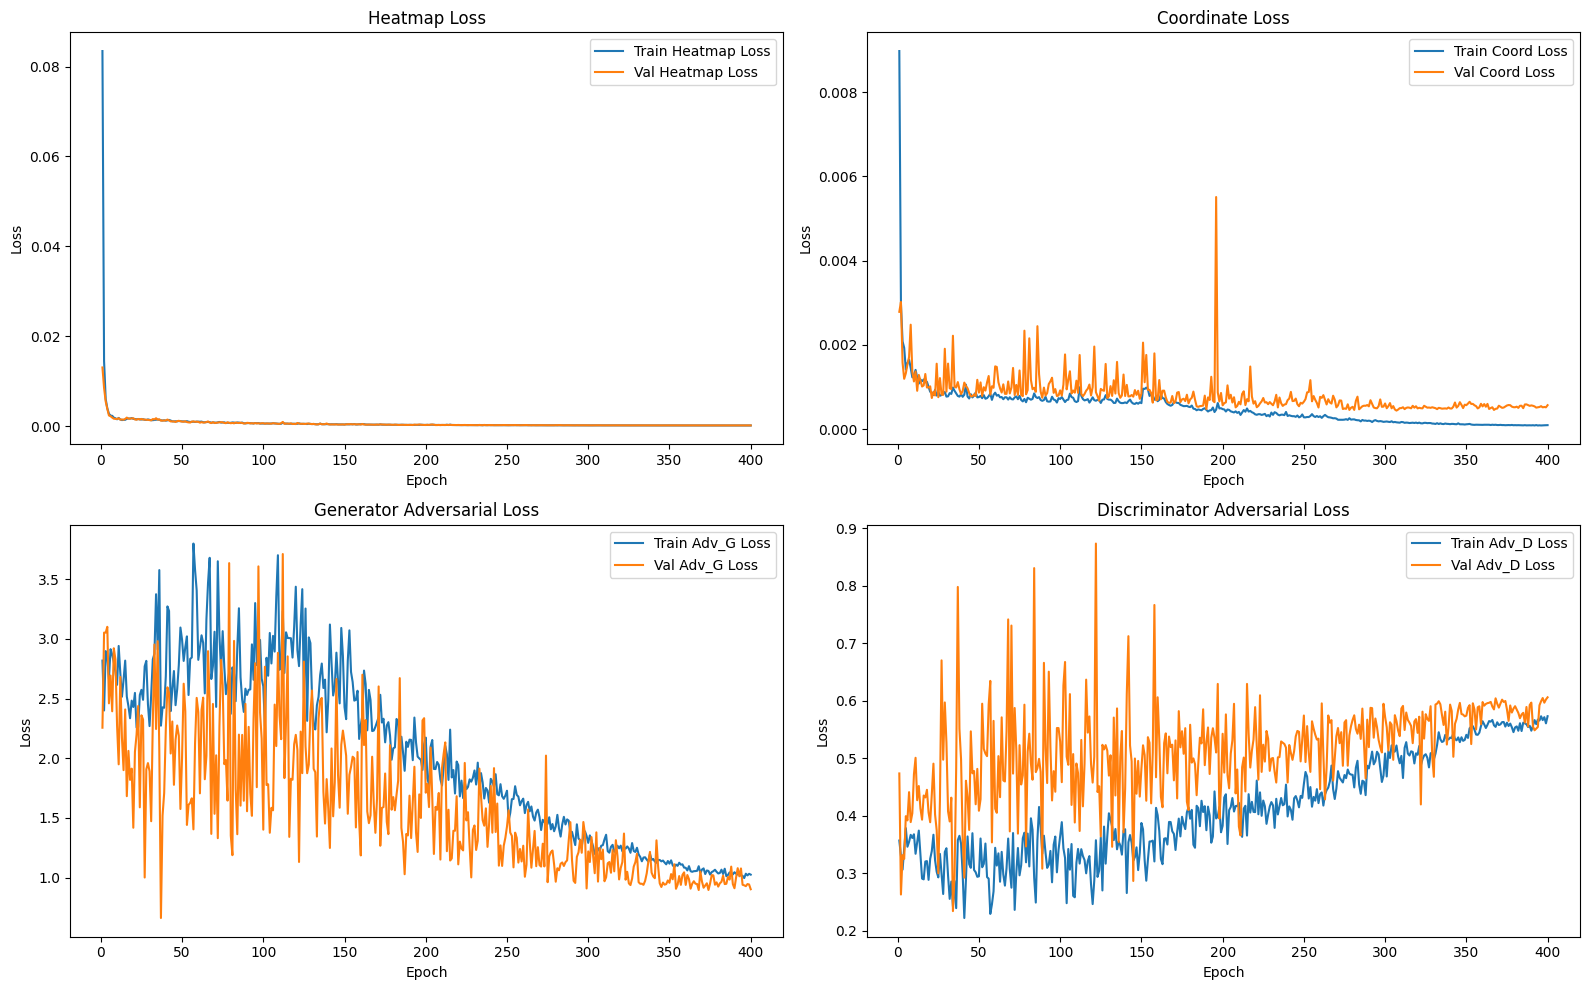

In [20]:
import matplotlib.pyplot as plt

# Extract individual loss components
train_heatmap = [log['heatmap'] for log in train_losses]
val_heatmap = [log['heatmap'] for log in val_losses]

train_coord = [log['coord'] for log in train_losses]
val_coord = [log['coord'] for log in val_losses]

train_adv_G = [log['adv_G'] for log in train_losses]
val_adv_G = [log['adv_G'] for log in val_losses]

train_adv_D = [log['adv_D'] for log in train_losses]
val_adv_D = [log['adv_D'] for log in val_losses]

# Epoch range
epochs = range(1, len(train_losses) + 1)

# Plotting
plt.figure(figsize=(16, 10))

plt.subplot(2, 2, 1)
plt.plot(epochs, train_heatmap, label='Train Heatmap Loss')
plt.plot(epochs, val_heatmap, label='Val Heatmap Loss')
plt.title('Heatmap Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(epochs, train_coord, label='Train Coord Loss')
plt.plot(epochs, val_coord, label='Val Coord Loss')
plt.title('Coordinate Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(epochs, train_adv_G, label='Train Adv_G Loss')
plt.plot(epochs, val_adv_G, label='Val Adv_G Loss')
plt.title('Generator Adversarial Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(epochs, train_adv_D, label='Train Adv_D Loss')
plt.plot(epochs, val_adv_D, label='Val Adv_D Loss')
plt.title('Discriminator Adversarial Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

<center><b> The End </b></center>